
# ICLR

### test

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from time import time
import math
import os
from os import makedirs
# 표준 라이브러리
import math
import os
import pickle
import time
from typing import Callable
from os import path, makedirs

# 외부 라이브러리
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import imageio
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd.functional import jacobian
from torch.func import jacrev, vmap
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import pyplot as plt

parameters = {
  "x_0": 0,
  "sigma": 0.1,
  "eval_traj_len": 50,
  "rho": 0.5
}


# ============================
# 1. 환경 dynamics 정의
# ============================


# 0) 기본 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 결과 저장을 위한 디렉토리 생성



d, m = 10, 10
dimension = d

# 데이터 로드
from os import path, makedirs


try:
    matrix = np.load("gym_lqr/gym_lqr/envs/data/matrix_10d_10d.npz")
except FileNotFoundError:
    print("Error: matrix_10d_10d.npz not found. Using random matrices.")
    A_np = np.random.randn(d, d)
    B_np = np.random.randn(d, m)


A = torch.from_numpy(matrix['A']).float().to(device)
B = torch.from_numpy(matrix['B']).float().to(device)


outer_iters = 25 # 전체 정책 반복 횟수
num_steps = 2000*10
batch_size = 256
exponent = 0.5

lr_v = 1e-4    # 가치 네트워크 학습률
# sigma = 0.1
sigma = parameters['sigma']


# 평가용 하이퍼파라미터
eval_num_traj = 30        # 평가 시뮬레이션 궤적 수
eval_traj_len = parameters['eval_traj_len']       # 각 궤적의 길이
eval_dt= 0.02
eval_x0_weight = 0.
rho = parameters['rho']      # 할인율
gamma = math.exp(-rho * eval_dt) # 스텝마다의 할인율

print(gamma)

#results_dir = f"results/ms-iclr/pinn-pi/lqr_{m}d_x0={eval_x0_weight}_sigma={sigma}_eval_traj_len={eval_num_traj}"
results_dir = f"results/sac/lqr_{m}d_x0={parameters['x_0']}_sigma={sigma}_eval_traj_len={eval_num_traj}_num_steps={num_steps}_outer{outer_iters}_rho={rho}"
makedirs(results_dir, exist_ok=True)


print(gym.__file__)

print(A.shape)
print(B.shape)



# drift 함수: b(x,u) = Ax + uB
def b(x, u):
    # x: [B, d], u: [B, m]
    return x @ A.T + u @ B

# diffusion 함수: constant diagonal noise
def sigma(x, u):
    # 고정된 대각 행렬 (작은 스케일)
    S = 0.1 * torch.eye(d, device=device)
    return S.unsqueeze(0).expand(x.shape[0], d, d)

# reward 함수 (running cost): r(x,u) = -5||x||^2 - ||u||^2
def r(x, u):
    cost_x = 5.0 * torch.sum(x**2, dim=1)
    cost_u = torch.sum(u**2, dim=1)
    return -(cost_x + cost_u)

# 도메인 클리핑
X_min, X_max = X_domain = torch.tensor([[-1.0]*d, [1.0]*d], device=device)
U_min, U_max = U_domain = torch.tensor([[-1.0]*m, [1.0]*m], device=device)

d = X_domain.shape[1]
m = U_domain.shape[1]


# ============================
# 2. SAC 구성 요소 정의
# ============================

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[256,256]):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Actor: state -> Gaussian(mean, log_std)
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256], log_std_min=-20, log_std_max=2):
        super().__init__()
        self.net = MLP(state_dim, 2*action_dim, hidden_dims)
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

    def forward(self, x):
        out = self.net(x)
        mu, log_std = torch.chunk(out, 2, dim=-1)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        std = torch.exp(log_std)
        return mu, std

    def sample(self, x, _eps=1e-9):
        mu, std = self.forward(x)
        eps = torch.randn_like(mu)
        action = mu + eps * std
        action_tanh = U_max[0] * torch.tanh(action)
        log_prob = -0.5 * ((eps**2) + np.log(2*torch.pi))-torch.log((U_max[0] * torch.abs(mu)) + _eps)-torch.log(1-(action_tanh/U_max[0])**2 + _eps)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        # 액션을 도메인에 맞춰 tanh 스케일링
        return action_tanh, log_prob

# Q-network: state, action -> Q-value
class QNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256]):
        super().__init__()
        self.net = MLP(state_dim+action_dim, 1, hidden_dims)

    def forward(self, x, u):
        xu = torch.cat([x, u], dim=-1)
        return self.net(xu)

# Replay buffer
def soft_update(net, target_net, tau):
    for p, tp in zip(net.parameters(), target_net.parameters()):
        tp.data.copy_(tau * p.data + (1 - tau) * tp.data)

class ReplayBuffer:
    def __init__(self, max_size=1_000_000):
        self.buffer = deque(maxlen=max_size)

    def add(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = zip(*batch)
        return (torch.stack(state), torch.stack(action),
                torch.tensor(reward, device=device).unsqueeze(1),
                torch.stack(next_state))



# ============================
# 3. 학습 파라미터 및 네트워크 초기화
# ============================

# 하이퍼파라미터

eval_dt= 0.02
tau = eval_dt
gamma = math.exp(-rho * eval_dt)
# gamma = 0.99
alpha = 0.2  # 온도 계수
lr = 3e-4
batch_size = 256
num_steps = 20000
start_steps = 200
update_after = 200
update_every = 1

actor = Actor(d, m).to(device)
q = QNet(d, m).to(device)
q_target = QNet(d, m).to(device)

# 타겟 네트워크 초기화
q_target.load_state_dict(q.state_dict())

# Optimizers
actor_opt = optim.Adam(actor.parameters(), lr=lr)
q_opt = optim.Adam(q.parameters(), lr=lr)

# Replay buffer 생성
replay = ReplayBuffer()

# 초기 상태 샘플링 함수
def sample_initial_state(batch_size=1):
    if parameters['x_0']==0:
        x0 = torch.zeros(batch_size, d, device=device)
    elif parameters['x_0']==1:
        x0 = torch.ones(batch_size, d, device=device)
    else:
        x0 = parameters['x_0']*torch.ones(batch_size, d, device=device)
        
    return x0

# 평가용 하이퍼파라미터\
# rho = 0.5      # 할인율
lam = 0.1      # 엔트로피 가중치
eval_num_traj = 30        # 평가 시뮬레이션 궤적 수
# eval_traj_len = 100       # 각 궤적의 길이
# eval_dt = 0.005            # 시뮬레이션 시간 스텝
# gamma = math.exp(-rho * eval_dt) # 스텝마다의 할인율

print(gamma)


@torch.no_grad()
def evaluate_policy(policy_net, num_traj, traj_len, dt):
    print('Start evaluating')
    policy_net.eval() # 평가 모드
    total_rewards = []
    

    # 초기 상태는 0 벡터로 시작
    # x = torch.zeros(num_traj, d, device=device)
    x = 0.1 * torch.ones(num_traj, d, device=device)
    episode_reward = torch.zeros(num_traj, device=device)
    x_norm_hist = torch.zeros(num_traj, traj_len, device = device)
    
    for t in range(traj_len):
        # sample from policy
        #print(f'state shape: {x.shape}')
        u = policy_net.sample(x)[0].squeeze(1) # [num_traj, m]
        #print(u.shape)
        
        # 보상 계산
        current_reward = r(x, u) # [B]
        episode_reward += current_reward * (gamma ** t) # [B]
        
        # 다음 상태 계산 (Euler-Maruyama)
        drift_term = b(x, u) # [num_traj, d]
        diffusion_term = (sigma(x, u) @ torch.randn(num_traj, d, 1, device=device)).squeeze(2)
        #print(f'diffusion term shape: {diffusion_term.shape}')

        #print(x.shape, drift_term.shape, diffusion_term.shape)
        x = x + drift_term * dt + diffusion_term * np.sqrt(dt)
        #x = torch.clamp(x, X_domain[0][0], X_domain[1][0])
        x_norm_hist[:,t] = torch.norm(x, dim=1)

    x_norm_hist = torch.mean(x_norm_hist, dim=0) 
    policy_net.train() # 다시 학습 모드로
    return torch.mean(episode_reward), x_norm_hist


avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)

print(avg_reward)


# ============================
# 4. 메인 학습 루프
# ============================

torch.autograd.set_detect_anomaly(True)
reward_history = []
x_norm_hist_hist = torch.zeros(num_steps, eval_traj_len, device=device)
start = time.time()
state = sample_initial_state()
for t in range(0, num_steps):
    # 1) 행동 선택
    if t < start_steps:
        action = torch.rand(1, m, device=device) * 2 - 1  # 탐사용 랜덤 액션
    else:
        action, _ = actor.sample(state)

    # 2) 환경 전이 (Euler-Maruyama integration)
    dt = eval_dt
    drift = b(state, action) * dt
    noise = sigma(state, action)
    dW = torch.randn_like(state) * np.sqrt(dt)
    next_state = state + drift + (noise @ dW.unsqueeze(-1)).squeeze(-1)
    # 도메인 클리핑
    next_state = torch.max(torch.min(next_state, X_max), X_min)

    # 3) 보상 계산
    reward = r(state, action)

    # 4) 리플레이 버퍼에 저장
    replay.add((state.squeeze(0).detach(), action.squeeze(0).detach(), reward, next_state.squeeze(0).detach()))
    state = next_state.detach()

    # 5) 네트워크 업데이트
    updated = False
    if t >= update_after and len(replay.buffer) >= batch_size:
        for _ in range(update_every):
            s, u, rew, s2 = replay.sample(batch_size)

            # 타겟 Q 값 계산
            with torch.no_grad():
                a2, logp2 = actor.sample(s2)
                q_t = q_target(s2, a2)
                y = rew + gamma * (q_t - alpha * logp2)

            # Q 함수 업데이트
            q_loss = nn.MSELoss()(q(s, u), y)
            q_opt.zero_grad(); q_loss.backward(); q_opt.step()

            # 정책 업데이트
            a_hat, logp_hat = actor.sample(s)
            q_val = q(s, a_hat)
            actor_loss = (alpha * logp_hat - q_val).mean()
            actor_opt.zero_grad(); actor_loss.backward(); actor_opt.step()

            # 타겟 네트워크 소프트 업데이트
            soft_update(q, q_target, tau)

        updated = True

    # 에피소드 재시작: 상태가 너무 커지면 초기화
    if torch.norm(state) > 10:
        state = sample_initial_state()

    if t % 10 == 0 and updated:
        avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)
        avg_reward = avg_reward.item()
        reward_history.append(avg_reward)
        x_norm_hist_hist[t, :] = x_norm_hist
        print(f"{t}/{num_steps} Evaluation Average Reward: {avg_reward:.4e} Time: {time.time() - start:.2f}s")

    # 로그 출력
    if t % 100 == 0:
        print(f"Step {t}: Reward {reward.item():.3f} ")

print("Training finished.")



# 보상 기록 저장
reward_file = os.path.join(results_dir, "reward_history.npy")
np.save(reward_file, np.array(reward_history))
print(f"Reward history saved to {reward_file}")

reward_file = os.path.join(results_dir, "reward_history.npy")
reward_history = np.load(reward_file)
print("Loaded reward history")

from matplotlib import pyplot as plt

print(len(reward_history))
# reward_history = reward_history[:70]
# 보상 그래프 시각화 및 저장
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(reward_history) + 1), reward_history, marker='o')

plt.title("Evaluation Reward per Iteration")
plt.xlabel("Outer Iteration")
plt.ylabel("Average Total Reward")
plt.grid(True)
plt.yscale('linear')
# plt.yscale('symlog')

plt.show()
plot_file = os.path.join(results_dir, "reward_plot.png")
plt.savefig(plot_file)
print(f"Reward plot saved to {plot_file}")

Using device: cuda
0.9900498337491681
/home/boiledcorn/minseok/relaxed_stochastic_control/.venv/lib/python3.12/site-packages/gymnasium/__init__.py
torch.Size([10, 10])
torch.Size([10, 10])
0.9900498337491681
Start evaluating
tensor(-210.8900, device='cuda:0')
Step 0: Reward -3.616 
Step 100: Reward -5.486 
Step 200: Reward -51.657 
Start evaluating
260/20000 Evaluation Average Reward: -2.0702e+02 Time: 1.76s
Start evaluating
270/20000 Evaluation Average Reward: -2.0459e+02 Time: 2.63s
Start evaluating
280/20000 Evaluation Average Reward: -1.8734e+02 Time: 3.49s
Start evaluating
290/20000 Evaluation Average Reward: -1.6696e+02 Time: 4.33s
Start evaluating
300/20000 Evaluation Average Reward: -1.6411e+02 Time: 5.22s
Step 300: Reward -53.931 
Start evaluating
310/20000 Evaluation Average Reward: -1.5407e+02 Time: 6.07s
Start evaluating
320/20000 Evaluation Average Reward: -1.4093e+02 Time: 7.01s
Start evaluating
330/20000 Evaluation Average Reward: -1.3517e+02 Time: 7.81s
Start evaluating

KeyboardInterrupt: 

### [looping fix] sigma = 0.1, x_0 = 0, umax = 3, xmax = 3, xavier scale = None

0.9900498337491681
Start evaluating
tensor(-2673.3843)
Step 0: Reward -5.877 
Step 100: Reward -5.761 
Step 200: Reward -32.402 
Start evaluating
Evaluation Average Reward: -2.3185e+03 Time: 1.87s
Step 300: Reward -246.031 
Start evaluating
Evaluation Average Reward: -8.1736e+02 Time: 4.78s
Step 400: Reward -525.612 
Start evaluating
Evaluation Average Reward: -9.7970e+02 Time: 7.88s
Step 500: Reward -500.491 
Start evaluating
Evaluation Average Reward: -4.1186e+02 Time: 10.84s
Step 600: Reward -528.248 
Start evaluating
Evaluation Average Reward: -3.2850e+02 Time: 13.87s
Step 700: Reward -519.376 
Start evaluating
Evaluation Average Reward: -3.2264e+02 Time: 16.76s
Step 800: Reward -520.889 
Start evaluating
Evaluation Average Reward: -5.9702e+02 Time: 19.57s
Step 900: Reward -513.359 
Start evaluating
Evaluation Average Reward: -5.0763e+02 Time: 22.39s
Step 1000: Reward -529.732 
Start evaluating
Evaluation Average Reward: -3.3930e+02 Time: 25.30s
Step 1100: Reward -525.946 
Start ev

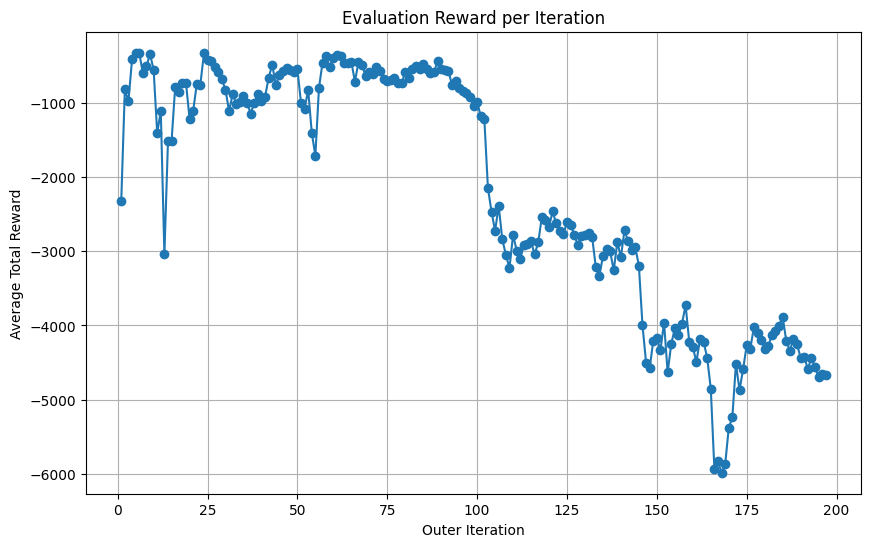

Reward plot saved to results/ms-iclr/sac/lqr_10d_sigma_0p1_u[-3,3]_x[-3,3]_xavierscale=None/reward_plot.png


<Figure size 640x480 with 0 Axes>

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from time import time
import math
import os
from os import makedirs

# ============================
# 1. 환경 dynamics 정의
# ============================

# 상태-행동 차원 설정
device = "cpu"  # torch.device("cuda" if torch.cuda.is_available() else "cpu")

d, m = 10, 10

_sigma = 0.1

# 데이터 로드
from os import path, makedirs

try:
    matrix = np.load("gym_lqr/gym_lqr/envs/data/matrix_10d_10d.npz")
except FileNotFoundError:
    print("Error: matrix_10d_10d.npz not found. Using random matrices.")
    A_np = np.random.randn(d, d)
    B_np = np.random.randn(d, m)


A = torch.from_numpy(matrix['A']).float().to(device)
B = torch.from_numpy(matrix['B']).float().to(device)

# drift 함수: b(x,u) = Ax + uB
def b(x, u):
    # x: [B, d], u: [B, m]
    return x @ A.T + u @ B

# diffusion 함수: constant diagonal noise
def sigma(x, u):
    # 고정된 대각 행렬 (작은 스케일)
    S = _sigma * torch.eye(d, device=device)
    return S.unsqueeze(0).expand(x.shape[0], d, d)

# reward 함수 (running cost): r(x,u) = -5||x||^2 - ||u||^2
def r(x, u):
    cost_x = 5.0 * torch.sum(x**2, dim=1)
    cost_u = torch.sum(u**2, dim=1)
    return -(cost_x + cost_u)

# 도메인 클리핑
# max_x = 10
max_x = 3
# max_u = 10
max_u = 3
X_min, X_max = X_domain = torch.tensor([[-1 * max_x]*d, [max_x]*d], device=device)
U_min, U_max = U_domain = torch.tensor([[-1 * max_u]*m, [max_u]*m], device=device)


# ============================
# 2. SAC 구성 요소 정의
# ============================

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[256,256]):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Actor: state -> Gaussian(mean, log_std)
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256], log_std_min=-20, log_std_max=2):
        super().__init__()
        self.net = MLP(state_dim, 2*action_dim, hidden_dims)
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

    def forward(self, x):
        out = self.net(x)
        mu, log_std = torch.chunk(out, 2, dim=-1)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        std = torch.exp(log_std)
        return mu, std

    def sample(self, x, _eps=1e-9):
        mu, std = self.forward(x)
        eps = torch.randn_like(mu)
        action = mu + eps * std
        action_tanh = U_max[0] * torch.tanh(action)
        log_prob = -0.5 * ((eps**2) + np.log(2*torch.pi))-torch.log((U_max[0] * torch.abs(mu)) + _eps)-torch.log(1-(action_tanh/U_max[0])**2 + _eps)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        # 액션을 도메인에 맞춰 tanh 스케일링
        return action_tanh, log_prob

# Q-network: state, action -> Q-value
class QNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256]):
        super().__init__()
        self.net = MLP(state_dim+action_dim, 1, hidden_dims)

    def forward(self, x, u):
        xu = torch.cat([x, u], dim=-1)
        return self.net(xu)

# Replay buffer
def soft_update(net, target_net, tau):
    for p, tp in zip(net.parameters(), target_net.parameters()):
        tp.data.copy_(tau * p.data + (1 - tau) * tp.data)

class ReplayBuffer:
    def __init__(self, max_size=1_000_000):
        self.buffer = deque(maxlen=max_size)

    def add(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = zip(*batch)
        return (torch.stack(state), torch.stack(action),
                torch.tensor(reward, device=device).unsqueeze(1),
                torch.stack(next_state))


# ============================
# 3. 학습 파라미터 및 네트워크 초기화
# ============================

# 하이퍼파라미터
rho = 0.5
eval_dt= 0.02
tau = eval_dt
gamma = math.exp(-rho * eval_dt)
# gamma = 0.99
alpha = 0.2  # 온도 계수
lr = 3e-4
batch_size = 256
num_steps = 20000
update_every = 1

start_steps = 200
update_after = 200

plot_every = 100
plot_step = plot_every / update_every

actor = Actor(d, m).to(device)
q = QNet(d, m).to(device)
q_target = QNet(d, m).to(device)

# 타겟 네트워크 초기화
q_target.load_state_dict(q.state_dict())

# Optimizers
actor_opt = optim.Adam(actor.parameters(), lr=lr)
q_opt = optim.Adam(q.parameters(), lr=lr)

# Replay buffer 생성
replay = ReplayBuffer()

# 초기 상태 샘플링 함수
def sample_initial_state(batch_size=1):
    x0 = torch.zeros(batch_size, d, device=device)
    return x0

# 평가용 하이퍼파라미터\
# rho = 0.5      # 할인율
lam = 0.1      # 엔트로피 가중치
eval_num_traj = 30        # 평가 시뮬레이션 궤적 수
eval_traj_len = 100       # 각 궤적의 길이
# eval_dt = 0.005            # 시뮬레이션 시간 스텝
# gamma = math.exp(-rho * eval_dt) # 스텝마다의 할인율

print(gamma)

xavier_gain = None

# 결과 저장을 위한 디렉토리 생성
results_dir = f"results/ms-iclr/sac/lqr_{m}d_sigma_0p1_u[-{max_u},{max_u}]_x[-{max_x},{max_x}]_xavierscale={xavier_gain}"
makedirs(results_dir, exist_ok=True)



@torch.no_grad()
def evaluate_policy(policy_net, num_traj, traj_len, dt):
    print('Start evaluating')
    policy_net.eval() # 평가 모드
    total_rewards = []
    

    # 초기 상태는 0 벡터로 시작
    # x = torch.zeros(num_traj, d, device=device)
    x = 0.1 * torch.ones(num_traj, d, device=device)
    episode_reward = torch.zeros(num_traj, device=device)
    x_norm_hist = torch.zeros(num_traj, traj_len, device = device)
    
    for t in range(traj_len):
        # sample from policy
        #print(f'state shape: {x.shape}')
        u = policy_net.sample(x)[0].squeeze(1) # [num_traj, m]
        #print(u.shape)
        
        # 보상 계산
        current_reward = r(x, u) # [B]
        episode_reward += current_reward * (gamma ** t) # [B]
        
        # 다음 상태 계산 (Euler-Maruyama)
        drift_term = b(x, u) # [num_traj, d]
        diffusion_term = (sigma(x, u) @ torch.randn(num_traj, d, 1, device=device)).squeeze(2)
        #print(f'diffusion term shape: {diffusion_term.shape}')

        #print(x.shape, drift_term.shape, diffusion_term.shape)
        x = x + drift_term * dt + diffusion_term * np.sqrt(dt)
        #x = torch.clamp(x, X_domain[0][0], X_domain[1][0])
        x_norm_hist[:,t] = torch.norm(x, dim=1)

    x_norm_hist = torch.mean(x_norm_hist, dim=0) 
    policy_net.train() # 다시 학습 모드로
    return torch.mean(episode_reward), x_norm_hist


avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)

print(avg_reward)

# ============================
# 4. 메인 학습 루프
# ============================

torch.autograd.set_detect_anomaly(True)
reward_history = []
x_norm_hist_hist = torch.zeros(num_steps, eval_traj_len, device=device)
start = time()
state = sample_initial_state()
for t in range(0, num_steps):
    # 1) 행동 선택
    if t < start_steps:
        action = torch.rand(1, m, device=device) * 2 - 1  # 탐사용 랜덤 액션
    else:
        action, _ = actor.sample(state)

    # 2) 환경 전이 (Euler-Maruyama integration)
    dt = eval_dt
    drift = b(state, action) * dt
    noise = sigma(state, action)
    dW = torch.randn_like(state) * np.sqrt(dt)
    next_state = state + drift + (noise @ dW.unsqueeze(-1)).squeeze(-1)
    # 도메인 클리핑
    next_state = torch.max(torch.min(next_state, X_max), X_min)

    # 3) 보상 계산
    reward = r(state, action)

    # 4) 리플레이 버퍼에 저장
    replay.add((state.squeeze(0).detach(), action.squeeze(0).detach(), reward, next_state.squeeze(0).detach()))
    state = next_state.detach()

    # 5) 네트워크 업데이트
    updated = False
    if t >= update_after and len(replay.buffer) >= batch_size:
        for _ in range(update_every):
            s, u, rew, s2 = replay.sample(batch_size)

            # 타겟 Q 값 계산
            with torch.no_grad():
                a2, logp2 = actor.sample(s2)
                q_t = q_target(s2, a2)
                y = rew + gamma * (q_t - alpha * logp2)

            # Q 함수 업데이트
            q_loss = nn.MSELoss()(q(s, u), y)
            q_opt.zero_grad(); q_loss.backward(); q_opt.step()

            # 정책 업데이트
            a_hat, logp_hat = actor.sample(s)
            q_val = q(s, a_hat)
            actor_loss = (alpha * logp_hat - q_val).mean()
            actor_opt.zero_grad(); actor_loss.backward(); actor_opt.step()

            # 타겟 네트워크 소프트 업데이트
            soft_update(q, q_target, tau)

        updated = True

    # 에피소드 재시작: 상태가 너무 커지면 초기화
    if torch.norm(state) > 10:
        state = sample_initial_state()

    if t % plot_step == 0 and updated:
        avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)
        avg_reward = avg_reward.item()
        reward_history.append(avg_reward)
        x_norm_hist_hist[t, :] = x_norm_hist
        print(f"Evaluation Average Reward: {avg_reward:.4e} Time: {time() - start:.2f}s")

    # 로그 출력
    if t % 100 == 0:
        print(f"Step {t}: Reward {reward.item():.3f} ")

print("Training finished.")


# 보상 기록 저장
reward_file = os.path.join(results_dir, "reward_history.npy")
np.save(reward_file, np.array(reward_history))
print(f"Reward history saved to {reward_file}")

reward_file = os.path.join(results_dir, "reward_history.npy")
reward_history = np.load(reward_file)
print("Loaded reward history")

from matplotlib import pyplot as plt

print(len(reward_history))
# reward_history = reward_history[:70]
# 보상 그래프 시각화 및 저장
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(reward_history) + 1), reward_history, marker='o')

plt.title("Evaluation Reward per Iteration")
plt.xlabel("Outer Iteration")
plt.ylabel("Average Total Reward")
plt.grid(True)
plt.yscale('linear')
# plt.yscale('symlog')

plt.show()
plot_file = os.path.join(results_dir, "reward_plot.png")
plt.savefig(plot_file)
print(f"Reward plot saved to {plot_file}")

### [looping fix] sigma = 0.01, x_0 = 0, umax = 3, xmax = 3, xavier scale = None

In [2]:
import numpy as np


try:
    matrix = np.load("gym_lqr/gym_lqr/envs/data/matrix_10d_10d.npz")
except FileNotFoundError:
    print("Error: matrix_10d_10d.npz not found. Using random matrices.")
    A_np = np.random.randn(d, d)
    B_np = np.random.randn(d, m)



0.9900498337491681
Start evaluating
tensor(-2649.5076)
Step 0: Reward -1.712 
Step 100: Reward -2.644 
Step 200: Reward -50.086 
Start evaluating
Evaluation Average Reward: -2.4562e+03 Time: 5.21s
Step 300: Reward -461.260 
Start evaluating
Evaluation Average Reward: -8.8356e+02 Time: 11.06s
Step 400: Reward -527.751 
Start evaluating
Evaluation Average Reward: -6.6898e+02 Time: 16.42s
Step 500: Reward -521.606 
Start evaluating
Evaluation Average Reward: -3.1832e+03 Time: 22.44s
Step 600: Reward -519.918 
Start evaluating
Evaluation Average Reward: -1.8213e+02 Time: 27.99s
Step 700: Reward -513.887 
Start evaluating
Evaluation Average Reward: -2.3519e+02 Time: 33.77s
Step 800: Reward -497.374 
Start evaluating
Evaluation Average Reward: -6.3543e+02 Time: 39.44s
Step 900: Reward -509.466 
Start evaluating
Evaluation Average Reward: -2.0295e+02 Time: 47.34s
Step 1000: Reward -508.307 
Start evaluating
Evaluation Average Reward: -3.3393e+02 Time: 53.34s
Step 1100: Reward -503.457 
Start 

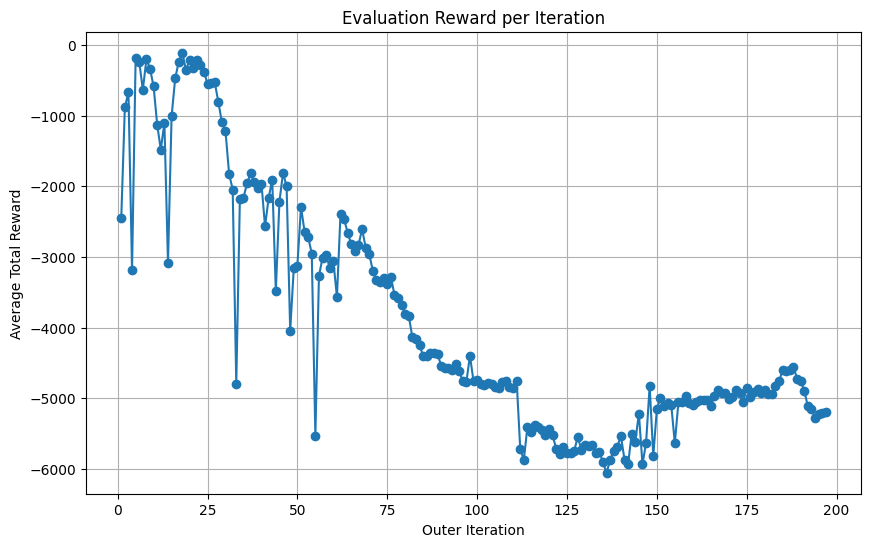

Reward plot saved to results/ms-iclr/sac/lqr_10d_sigma_0p1_u[-3,3]_x[-3,3]_xavierscale=None/reward_plot.png


<Figure size 640x480 with 0 Axes>

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from time import time
import math
import os
from os import makedirs

# ============================
# 1. 환경 dynamics 정의
# ============================

# 상태-행동 차원 설정
device = "cpu"  # torch.device("cuda" if torch.cuda.is_available() else "cpu")

d, m = 10, 10

sigma = 0.1

# 데이터 로드
from os import path, makedirs

try:
    matrix = np.load("gym_lqr/gym_lqr/envs/data/matrix_10d_10d.npz")
except FileNotFoundError:
    print("Error: matrix_10d_10d.npz not found. Using random matrices.")
    A_np = np.random.randn(d, d)
    B_np = np.random.randn(d, m)


A = torch.from_numpy(matrix['A']).float().to(device)
B = torch.from_numpy(matrix['B']).float().to(device)

# drift 함수: b(x,u) = Ax + uB
def b(x, u):
    # x: [B, d], u: [B, m]
    return x @ A.T + u @ B

# diffusion 함수: constant diagonal noise
def sigma(x, u):
    # 고정된 대각 행렬 (작은 스케일)
    S = sigma * torch.eye(d, device=device)
    return S.unsqueeze(0).expand(x.shape[0], d, d)

# reward 함수 (running cost): r(x,u) = -5||x||^2 - ||u||^2
def r(x, u):
    cost_x = 5.0 * torch.sum(x**2, dim=1)
    cost_u = torch.sum(u**2, dim=1)
    return -(cost_x + cost_u)

# 도메인 클리핑
# max_x = 10
max_x = 3
# max_u = 10
max_u = 3
X_min, X_max = X_domain = torch.tensor([[-1 * max_x]*d, [max_x]*d], device=device)
U_min, U_max = U_domain = torch.tensor([[-1 * max_u]*m, [max_u]*m], device=device)


# ============================
# 2. SAC 구성 요소 정의
# ============================

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[256,256]):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Actor: state -> Gaussian(mean, log_std)
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256], log_std_min=-20, log_std_max=2):
        super().__init__()
        self.net = MLP(state_dim, 2*action_dim, hidden_dims)
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

    def forward(self, x):
        out = self.net(x)
        mu, log_std = torch.chunk(out, 2, dim=-1)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        std = torch.exp(log_std)
        return mu, std

    def sample(self, x, _eps=1e-9):
        mu, std = self.forward(x)
        eps = torch.randn_like(mu)
        action = mu + eps * std
        action_tanh = U_max[0] * torch.tanh(action)
        log_prob = -0.5 * ((eps**2) + np.log(2*torch.pi))-torch.log((U_max[0] * torch.abs(mu)) + _eps)-torch.log(1-(action_tanh/U_max[0])**2 + _eps)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        # 액션을 도메인에 맞춰 tanh 스케일링
        return action_tanh, log_prob

# Q-network: state, action -> Q-value
class QNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256]):
        super().__init__()
        self.net = MLP(state_dim+action_dim, 1, hidden_dims)

    def forward(self, x, u):
        xu = torch.cat([x, u], dim=-1)
        return self.net(xu)

# Replay buffer
def soft_update(net, target_net, tau):
    for p, tp in zip(net.parameters(), target_net.parameters()):
        tp.data.copy_(tau * p.data + (1 - tau) * tp.data)

class ReplayBuffer:
    def __init__(self, max_size=1_000_000):
        self.buffer = deque(maxlen=max_size)

    def add(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = zip(*batch)
        return (torch.stack(state), torch.stack(action),
                torch.tensor(reward, device=device).unsqueeze(1),
                torch.stack(next_state))


# ============================
# 3. 학습 파라미터 및 네트워크 초기화
# ============================

# 하이퍼파라미터
rho = 0.5
eval_dt= 0.02
tau = eval_dt
gamma = math.exp(-rho * eval_dt)
# gamma = 0.99
alpha = 0.2  # 온도 계수
lr = 3e-4
batch_size = 256
num_steps = 20000
update_every = 1

start_steps = 200
update_after = 200

plot_every = 100
plot_step = plot_every / update_every

actor = Actor(d, m).to(device)
q = QNet(d, m).to(device)
q_target = QNet(d, m).to(device)

# 타겟 네트워크 초기화
q_target.load_state_dict(q.state_dict())

# Optimizers
actor_opt = optim.Adam(actor.parameters(), lr=lr)
q_opt = optim.Adam(q.parameters(), lr=lr)

# Replay buffer 생성
replay = ReplayBuffer()

# 초기 상태 샘플링 함수
def sample_initial_state(batch_size=1):
    x0 = torch.zeros(batch_size, d, device=device)
    return x0

# 평가용 하이퍼파라미터\
# rho = 0.5      # 할인율
lam = 0.1      # 엔트로피 가중치
eval_num_traj = 30        # 평가 시뮬레이션 궤적 수
eval_traj_len = 100       # 각 궤적의 길이
# eval_dt = 0.005            # 시뮬레이션 시간 스텝
# gamma = math.exp(-rho * eval_dt) # 스텝마다의 할인율

print(gamma)

xavier_gain = None

# 결과 저장을 위한 디렉토리 생성
results_dir = f"results/ms-iclr/sac/lqr_{m}d_sigma_0p1_u[-{max_u},{max_u}]_x[-{max_x},{max_x}]_xavierscale={xavier_gain}"
makedirs(results_dir, exist_ok=True)



@torch.no_grad()
def evaluate_policy(policy_net, num_traj, traj_len, dt):
    print('Start evaluating')
    policy_net.eval() # 평가 모드
    total_rewards = []
    

    # 초기 상태는 0 벡터로 시작
    # x = torch.zeros(num_traj, d, device=device)
    x = 0.1 * torch.ones(num_traj, d, device=device)
    episode_reward = torch.zeros(num_traj, device=device)
    x_norm_hist = torch.zeros(num_traj, traj_len, device = device)
    
    for t in range(traj_len):
        # sample from policy
        #print(f'state shape: {x.shape}')
        u = policy_net.sample(x)[0].squeeze(1) # [num_traj, m]
        #print(u.shape)
        
        # 보상 계산
        current_reward = r(x, u) # [B]
        episode_reward += current_reward * (gamma ** t) # [B]
        
        # 다음 상태 계산 (Euler-Maruyama)
        drift_term = b(x, u) # [num_traj, d]
        diffusion_term = (sigma(x, u) @ torch.randn(num_traj, d, 1, device=device)).squeeze(2)
        #print(f'diffusion term shape: {diffusion_term.shape}')

        #print(x.shape, drift_term.shape, diffusion_term.shape)
        x = x + drift_term * dt + diffusion_term * np.sqrt(dt)
        #x = torch.clamp(x, X_domain[0][0], X_domain[1][0])
        x_norm_hist[:,t] = torch.norm(x, dim=1)

    x_norm_hist = torch.mean(x_norm_hist, dim=0) 
    policy_net.train() # 다시 학습 모드로
    return torch.mean(episode_reward), x_norm_hist


avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)

print(avg_reward)

# ============================
# 4. 메인 학습 루프
# ============================

torch.autograd.set_detect_anomaly(True)
reward_history = []
x_norm_hist_hist = torch.zeros(num_steps, eval_traj_len, device=device)
start = time()
state = sample_initial_state()
for t in range(0, num_steps):
    # 1) 행동 선택
    if t < start_steps:
        action = torch.rand(1, m, device=device) * 2 - 1  # 탐사용 랜덤 액션
    else:
        action, _ = actor.sample(state)

    # 2) 환경 전이 (Euler-Maruyama integration)
    dt = eval_dt
    drift = b(state, action) * dt
    noise = sigma(state, action)
    dW = torch.randn_like(state) * np.sqrt(dt)
    next_state = state + drift + (noise @ dW.unsqueeze(-1)).squeeze(-1)
    # 도메인 클리핑
    next_state = torch.max(torch.min(next_state, X_max), X_min)

    # 3) 보상 계산
    reward = r(state, action)

    # 4) 리플레이 버퍼에 저장
    replay.add((state.squeeze(0).detach(), action.squeeze(0).detach(), reward, next_state.squeeze(0).detach()))
    state = next_state.detach()

    # 5) 네트워크 업데이트
    updated = False
    if t >= update_after and len(replay.buffer) >= batch_size:
        for _ in range(update_every):
            s, u, rew, s2 = replay.sample(batch_size)

            # 타겟 Q 값 계산
            with torch.no_grad():
                a2, logp2 = actor.sample(s2)
                q_t = q_target(s2, a2)
                y = rew + gamma * (q_t - alpha * logp2)

            # Q 함수 업데이트
            q_loss = nn.MSELoss()(q(s, u), y)
            q_opt.zero_grad(); q_loss.backward(); q_opt.step()

            # 정책 업데이트
            a_hat, logp_hat = actor.sample(s)
            q_val = q(s, a_hat)
            actor_loss = (alpha * logp_hat - q_val).mean()
            actor_opt.zero_grad(); actor_loss.backward(); actor_opt.step()

            # 타겟 네트워크 소프트 업데이트
            soft_update(q, q_target, tau)

        updated = True

    # 에피소드 재시작: 상태가 너무 커지면 초기화
    if torch.norm(state) > 10:
        state = sample_initial_state()

    if t % plot_step == 0 and updated:
        avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)
        avg_reward = avg_reward.item()
        reward_history.append(avg_reward)
        x_norm_hist_hist[t, :] = x_norm_hist
        print(f"Evaluation Average Reward: {avg_reward:.4e} Time: {time() - start:.2f}s")

    # 로그 출력
    if t % 100 == 0:
        print(f"Step {t}: Reward {reward.item():.3f} ")

print("Training finished.")


# 보상 기록 저장
reward_file = os.path.join(results_dir, "reward_history.npy")
np.save(reward_file, np.array(reward_history))
print(f"Reward history saved to {reward_file}")

reward_file = os.path.join(results_dir, "reward_history.npy")
reward_history = np.load(reward_file)
print("Loaded reward history")

from matplotlib import pyplot as plt

print(len(reward_history))
# reward_history = reward_history[:70]
# 보상 그래프 시각화 및 저장
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(reward_history) + 1), reward_history, marker='o')

plt.title("Evaluation Reward per Iteration")
plt.xlabel("Outer Iteration")
plt.ylabel("Average Total Reward")
plt.grid(True)
plt.yscale('linear')
# plt.yscale('symlog')

plt.show()
plot_file = os.path.join(results_dir, "reward_plot.png")
plt.savefig(plot_file)
print(f"Reward plot saved to {plot_file}")

### [looping fix] x_0 = 0, umax = 3, xmax = 3, xavier scale = None

0.9900498337491681
Start evaluating
tensor(-2591.3181)
Step 0: Reward -3.602 
Step 100: Reward -53.766 
Step 200: Reward -91.868 
Start evaluating
Evaluation Average Reward: -1.7527e+03 Time: 5.73s
Start evaluating
Evaluation Average Reward: -1.3848e+03 Time: 12.73s
Start evaluating
Evaluation Average Reward: -3.3614e+02 Time: 19.39s
Start evaluating
Evaluation Average Reward: -2.4869e+02 Time: 25.96s
Start evaluating
Evaluation Average Reward: -4.2743e+02 Time: 31.76s
Step 300: Reward -497.040 
Start evaluating
Evaluation Average Reward: -4.7693e+02 Time: 39.71s
Start evaluating
Evaluation Average Reward: -7.4096e+02 Time: 47.66s
Start evaluating
Evaluation Average Reward: -4.9163e+02 Time: 55.88s
Start evaluating
Evaluation Average Reward: -9.8874e+02 Time: 63.48s
Start evaluating
Evaluation Average Reward: -1.7388e+03 Time: 73.31s
Start evaluating
Evaluation Average Reward: -1.4984e+03 Time: 81.24s
Start evaluating
Evaluation Average Reward: -1.4804e+03 Time: 89.61s
Start evaluating

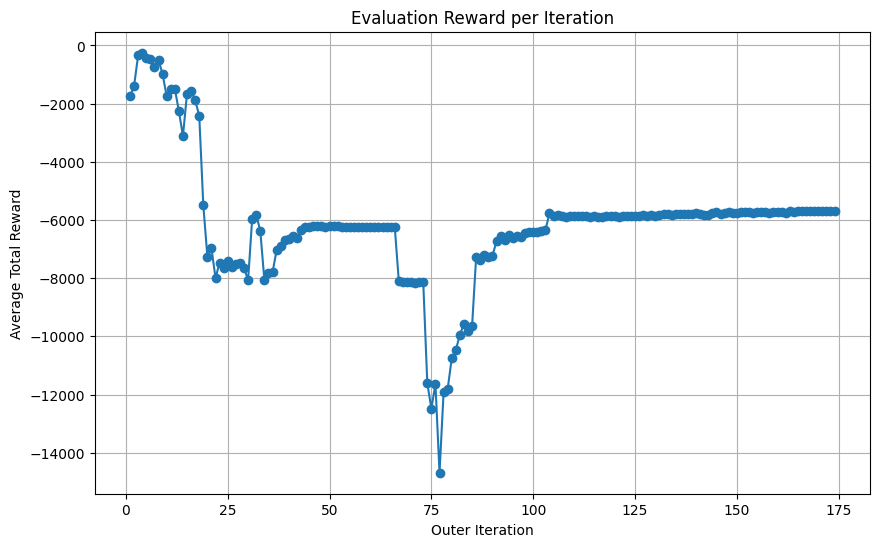

Reward plot saved to results/ms-iclr/sac/lqr_10d_sigma_0p1_u[-3,3]_x[-3,3]_xavierscale=None/reward_plot.png


<Figure size 640x480 with 0 Axes>

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from time import time
import math
import os
from os import makedirs

# ============================
# 1. 환경 dynamics 정의
# ============================

# 상태-행동 차원 설정
device = "cpu"  # torch.device("cuda" if torch.cuda.is_available() else "cpu")

d, m = 10, 10

# 데이터 로드
from os import path, makedirs

try:
    matrix = np.load("gym_lqr/gym_lqr/envs/data/matrix_10d_10d.npz")
except FileNotFoundError:
    print("Error: matrix_10d_10d.npz not found. Using random matrices.")
    A_np = np.random.randn(d, d)
    B_np = np.random.randn(d, m)


A = torch.from_numpy(matrix['A']).float().to(device)
B = torch.from_numpy(matrix['B']).float().to(device)

# drift 함수: b(x,u) = Ax + uB
def b(x, u):
    # x: [B, d], u: [B, m]
    return x @ A.T + u @ B

# diffusion 함수: constant diagonal noise
def sigma(x, u):
    # 고정된 대각 행렬 (작은 스케일)
    S = 0.01 * torch.eye(d, device=device)
    return S.unsqueeze(0).expand(x.shape[0], d, d)

# reward 함수 (running cost): r(x,u) = -5||x||^2 - ||u||^2
def r(x, u):
    cost_x = 5.0 * torch.sum(x**2, dim=1)
    cost_u = torch.sum(u**2, dim=1)
    return -(cost_x + cost_u)

# 도메인 클리핑
# max_x = 10
max_x = 3
# max_u = 10
max_u = 3
X_min, X_max = X_domain = torch.tensor([[-1 * max_x]*d, [max_x]*d], device=device)
U_min, U_max = U_domain = torch.tensor([[-1 * max_u]*m, [max_u]*m], device=device)


# ============================
# 2. SAC 구성 요소 정의
# ============================

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[256,256]):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Actor: state -> Gaussian(mean, log_std)
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256], log_std_min=-20, log_std_max=2):
        super().__init__()
        self.net = MLP(state_dim, 2*action_dim, hidden_dims)
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

    def forward(self, x):
        out = self.net(x)
        mu, log_std = torch.chunk(out, 2, dim=-1)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        std = torch.exp(log_std)
        return mu, std

    def sample(self, x, _eps=1e-9):
        mu, std = self.forward(x)
        eps = torch.randn_like(mu)
        action = mu + eps * std
        action_tanh = U_max[0] * torch.tanh(action)
        log_prob = -0.5 * ((eps**2) + np.log(2*torch.pi))-torch.log((U_max[0] * torch.abs(mu)) + _eps)-torch.log(1-(action_tanh/U_max[0])**2 + _eps)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        # 액션을 도메인에 맞춰 tanh 스케일링
        return action_tanh, log_prob

# Q-network: state, action -> Q-value
class QNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256]):
        super().__init__()
        self.net = MLP(state_dim+action_dim, 1, hidden_dims)

    def forward(self, x, u):
        xu = torch.cat([x, u], dim=-1)
        return self.net(xu)

# Replay buffer
def soft_update(net, target_net, tau):
    for p, tp in zip(net.parameters(), target_net.parameters()):
        tp.data.copy_(tau * p.data + (1 - tau) * tp.data)

class ReplayBuffer:
    def __init__(self, max_size=1_000_000):
        self.buffer = deque(maxlen=max_size)

    def add(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = zip(*batch)
        return (torch.stack(state), torch.stack(action),
                torch.tensor(reward, device=device).unsqueeze(1),
                torch.stack(next_state))


# ============================
# 3. 학습 파라미터 및 네트워크 초기화
# ============================

# 하이퍼파라미터
rho = 0.5
eval_dt= 0.02
tau = eval_dt
gamma = math.exp(-rho * eval_dt)
# gamma = 0.99
alpha = 0.2  # 온도 계수
lr = 3e-4
batch_size = 256
num_steps = 2000
update_every = 10

start_steps = 100
update_after = 0

plot_every = 100
plot_step = plot_every / update_every

actor = Actor(d, m).to(device)
q = QNet(d, m).to(device)
q_target = QNet(d, m).to(device)

# 타겟 네트워크 초기화
q_target.load_state_dict(q.state_dict())

# Optimizers
actor_opt = optim.Adam(actor.parameters(), lr=lr)
q_opt = optim.Adam(q.parameters(), lr=lr)

# Replay buffer 생성
replay = ReplayBuffer()

# 초기 상태 샘플링 함수
def sample_initial_state(batch_size=1):
    x0 = torch.zeros(batch_size, d, device=device)
    return x0

# 평가용 하이퍼파라미터\
# rho = 0.5      # 할인율
lam = 0.1      # 엔트로피 가중치
eval_num_traj = 30        # 평가 시뮬레이션 궤적 수
eval_traj_len = 100       # 각 궤적의 길이
# eval_dt = 0.005            # 시뮬레이션 시간 스텝
# gamma = math.exp(-rho * eval_dt) # 스텝마다의 할인율

print(gamma)

xavier_gain = None

# 결과 저장을 위한 디렉토리 생성
results_dir = f"results/ms-iclr/sac/lqr_{m}d_sigma_0p1_u[-{max_u},{max_u}]_x[-{max_x},{max_x}]_xavierscale={xavier_gain}"
makedirs(results_dir, exist_ok=True)



@torch.no_grad()
def evaluate_policy(policy_net, num_traj, traj_len, dt):
    print('Start evaluating')
    policy_net.eval() # 평가 모드
    total_rewards = []
    

    # 초기 상태는 0 벡터로 시작
    # x = torch.zeros(num_traj, d, device=device)
    x = 0.1 * torch.ones(num_traj, d, device=device)
    episode_reward = torch.zeros(num_traj, device=device)
    x_norm_hist = torch.zeros(num_traj, traj_len, device = device)
    
    for t in range(traj_len):
        # sample from policy
        #print(f'state shape: {x.shape}')
        u = policy_net.sample(x)[0].squeeze(1) # [num_traj, m]
        #print(u.shape)
        
        # 보상 계산
        current_reward = r(x, u) # [B]
        episode_reward += current_reward * (gamma ** t) # [B]
        
        # 다음 상태 계산 (Euler-Maruyama)
        drift_term = b(x, u) # [num_traj, d]
        diffusion_term = (sigma(x, u) @ torch.randn(num_traj, d, 1, device=device)).squeeze(2)
        #print(f'diffusion term shape: {diffusion_term.shape}')

        #print(x.shape, drift_term.shape, diffusion_term.shape)
        x = x + drift_term * dt + diffusion_term * np.sqrt(dt)
        #x = torch.clamp(x, X_domain[0][0], X_domain[1][0])
        x_norm_hist[:,t] = torch.norm(x, dim=1)

    x_norm_hist = torch.mean(x_norm_hist, dim=0) 
    policy_net.train() # 다시 학습 모드로
    return torch.mean(episode_reward), x_norm_hist


avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)

print(avg_reward)

# ============================
# 4. 메인 학습 루프
# ============================

torch.autograd.set_detect_anomaly(True)
reward_history = []
x_norm_hist_hist = torch.zeros(num_steps, eval_traj_len, device=device)
start = time()
state = sample_initial_state()
for t in range(0, num_steps):
    # 1) 행동 선택
    if t < start_steps:
        action = torch.rand(1, m, device=device) * 2 - 1  # 탐사용 랜덤 액션
    else:
        action, _ = actor.sample(state)

    # 2) 환경 전이 (Euler-Maruyama integration)
    dt = eval_dt
    drift = b(state, action) * dt
    noise = sigma(state, action)
    dW = torch.randn_like(state) * np.sqrt(dt)
    next_state = state + drift + (noise @ dW.unsqueeze(-1)).squeeze(-1)
    # 도메인 클리핑
    next_state = torch.max(torch.min(next_state, X_max), X_min)

    # 3) 보상 계산
    reward = r(state, action)

    # 4) 리플레이 버퍼에 저장
    replay.add((state.squeeze(0).detach(), action.squeeze(0).detach(), reward, next_state.squeeze(0).detach()))
    state = next_state.detach()

    # 5) 네트워크 업데이트
    updated = False
    if t >= update_after and len(replay.buffer) >= batch_size:
        for _ in range(update_every):
            s, u, rew, s2 = replay.sample(batch_size)

            # 타겟 Q 값 계산
            with torch.no_grad():
                a2, logp2 = actor.sample(s2)
                q_t = q_target(s2, a2)
                y = rew + gamma * (q_t - alpha * logp2)

            # Q 함수 업데이트
            q_loss = nn.MSELoss()(q(s, u), y)
            q_opt.zero_grad(); q_loss.backward(); q_opt.step()

            # 정책 업데이트
            a_hat, logp_hat = actor.sample(s)
            q_val = q(s, a_hat)
            actor_loss = (alpha * logp_hat - q_val).mean()
            actor_opt.zero_grad(); actor_loss.backward(); actor_opt.step()

            # 타겟 네트워크 소프트 업데이트
            soft_update(q, q_target, tau)

        updated = True

    # 에피소드 재시작: 상태가 너무 커지면 초기화
    if torch.norm(state) > 10:
        state = sample_initial_state()

    if t % plot_step == 0 and updated:
        avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)
        avg_reward = avg_reward.item()
        reward_history.append(avg_reward)
        x_norm_hist_hist[t, :] = x_norm_hist
        print(f"Evaluation Average Reward: {avg_reward:.4e} Time: {time() - start:.2f}s")

    # 로그 출력
    if t % 100 == 0:
        print(f"Step {t}: Reward {reward.item():.3f} ")

print("Training finished.")


# 보상 기록 저장
reward_file = os.path.join(results_dir, "reward_history.npy")
np.save(reward_file, np.array(reward_history))
print(f"Reward history saved to {reward_file}")

reward_file = os.path.join(results_dir, "reward_history.npy")
reward_history = np.load(reward_file)
print("Loaded reward history")

from matplotlib import pyplot as plt

print(len(reward_history))
# reward_history = reward_history[:70]
# 보상 그래프 시각화 및 저장
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(reward_history) + 1), reward_history, marker='o')

plt.title("Evaluation Reward per Iteration")
plt.xlabel("Outer Iteration")
plt.ylabel("Average Total Reward")
plt.grid(True)
plt.yscale('linear')
# plt.yscale('symlog')

plt.show()
plot_file = os.path.join(results_dir, "reward_plot.png")
plt.savefig(plot_file)
print(f"Reward plot saved to {plot_file}")

### [looping fix] x_0 = 0, umax = 10, xmax = 10, xavier scale = None

0.9900498337491681
Start evaluating
tensor(-25490.5137)
Step 0: Reward -2.383 
Step 100: Reward -545.576 
Step 200: Reward -405.080 
Start evaluating
Evaluation Average Reward: -1.5603e+04 Time: 7.39s
Start evaluating
Evaluation Average Reward: -7.8726e+02 Time: 14.81s
Start evaluating
Evaluation Average Reward: -1.0054e+03 Time: 21.86s
Start evaluating
Evaluation Average Reward: -2.0866e+03 Time: 30.34s
Start evaluating
Evaluation Average Reward: -2.7597e+02 Time: 38.11s
Step 300: Reward -438.538 
Start evaluating
Evaluation Average Reward: -1.0643e+02 Time: 45.02s
Start evaluating
Evaluation Average Reward: -1.8104e+02 Time: 51.01s
Start evaluating
Evaluation Average Reward: -1.2802e+02 Time: 57.61s
Start evaluating
Evaluation Average Reward: -2.1305e+02 Time: 64.19s
Start evaluating
Evaluation Average Reward: -5.3594e+02 Time: 71.31s
Start evaluating
Evaluation Average Reward: -8.8602e+02 Time: 79.92s
Start evaluating
Evaluation Average Reward: -9.7537e+02 Time: 87.63s
Start evaluat

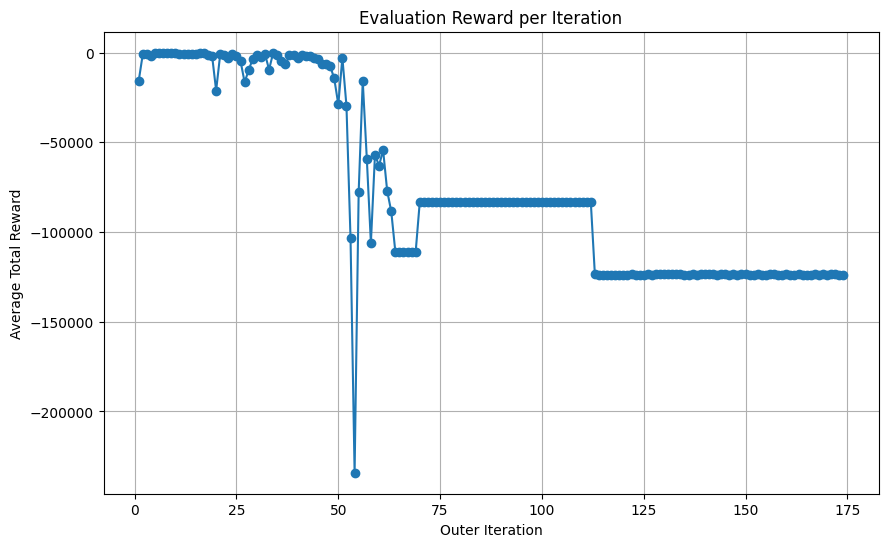

Reward plot saved to results/ms-iclr/sac/lqr_10d_sigma_0p1_u[-10,10]_x[-10,10]_xavierscale=None/reward_plot.png


<Figure size 640x480 with 0 Axes>

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from time import time
import math
import os
from os import makedirs

# ============================
# 1. 환경 dynamics 정의
# ============================

# 상태-행동 차원 설정
device = "cpu"  # torch.device("cuda" if torch.cuda.is_available() else "cpu")

d, m = 10, 10

# 데이터 로드
from os import path, makedirs

try:
    matrix = np.load("gym_lqr/gym_lqr/envs/data/matrix_10d_10d.npz")
except FileNotFoundError:
    print("Error: matrix_10d_10d.npz not found. Using random matrices.")
    A_np = np.random.randn(d, d)
    B_np = np.random.randn(d, m)


A = torch.from_numpy(matrix['A']).float().to(device)
B = torch.from_numpy(matrix['B']).float().to(device)

# drift 함수: b(x,u) = Ax + uB
def b(x, u):
    # x: [B, d], u: [B, m]
    return x @ A.T + u @ B

# diffusion 함수: constant diagonal noise
def sigma(x, u):
    # 고정된 대각 행렬 (작은 스케일)
    S = 0.01 * torch.eye(d, device=device)
    return S.unsqueeze(0).expand(x.shape[0], d, d)

# reward 함수 (running cost): r(x,u) = -5||x||^2 - ||u||^2
def r(x, u):
    cost_x = 5.0 * torch.sum(x**2, dim=1)
    cost_u = torch.sum(u**2, dim=1)
    return -(cost_x + cost_u)

# 도메인 클리핑
# max_x = 10
max_x = 10
# max_u = 10
max_u = 10
X_min, X_max = X_domain = torch.tensor([[-1 * max_x]*d, [max_x]*d], device=device)
U_min, U_max = U_domain = torch.tensor([[-1 * max_u]*m, [max_u]*m], device=device)


# ============================
# 2. SAC 구성 요소 정의
# ============================

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[256,256]):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Actor: state -> Gaussian(mean, log_std)
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256], log_std_min=-20, log_std_max=2):
        super().__init__()
        self.net = MLP(state_dim, 2*action_dim, hidden_dims)
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

    def forward(self, x):
        out = self.net(x)
        mu, log_std = torch.chunk(out, 2, dim=-1)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        std = torch.exp(log_std)
        return mu, std

    def sample(self, x, _eps=1e-9):
        mu, std = self.forward(x)
        eps = torch.randn_like(mu)
        action = mu + eps * std
        action_tanh = U_max[0] * torch.tanh(action)
        log_prob = -0.5 * ((eps**2) + np.log(2*torch.pi))-torch.log((U_max[0] * torch.abs(mu)) + _eps)-torch.log(1-(action_tanh/U_max[0])**2 + _eps)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        # 액션을 도메인에 맞춰 tanh 스케일링
        return action_tanh, log_prob

# Q-network: state, action -> Q-value
class QNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256]):
        super().__init__()
        self.net = MLP(state_dim+action_dim, 1, hidden_dims)

    def forward(self, x, u):
        xu = torch.cat([x, u], dim=-1)
        return self.net(xu)

# Replay buffer
def soft_update(net, target_net, tau):
    for p, tp in zip(net.parameters(), target_net.parameters()):
        tp.data.copy_(tau * p.data + (1 - tau) * tp.data)

class ReplayBuffer:
    def __init__(self, max_size=1_000_000):
        self.buffer = deque(maxlen=max_size)

    def add(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = zip(*batch)
        return (torch.stack(state), torch.stack(action),
                torch.tensor(reward, device=device).unsqueeze(1),
                torch.stack(next_state))


# ============================
# 3. 학습 파라미터 및 네트워크 초기화
# ============================

# 하이퍼파라미터
rho = 0.5
eval_dt= 0.02
tau = eval_dt
gamma = math.exp(-rho * eval_dt)
# gamma = 0.99
alpha = 0.2  # 온도 계수
lr = 3e-4
batch_size = 256
num_steps = 2000
start_steps = 100
update_after = 0
update_every = 10
plot_every = 100
plot_step = plot_every / update_every

actor = Actor(d, m).to(device)
q = QNet(d, m).to(device)
q_target = QNet(d, m).to(device)

# 타겟 네트워크 초기화
q_target.load_state_dict(q.state_dict())

# Optimizers
actor_opt = optim.Adam(actor.parameters(), lr=lr)
q_opt = optim.Adam(q.parameters(), lr=lr)

# Replay buffer 생성
replay = ReplayBuffer()

# 초기 상태 샘플링 함수
def sample_initial_state(batch_size=1):
    x0 = torch.zeros(batch_size, d, device=device)
    return x0

# 평가용 하이퍼파라미터\
# rho = 0.5      # 할인율
lam = 0.1      # 엔트로피 가중치
eval_num_traj = 30        # 평가 시뮬레이션 궤적 수
eval_traj_len = 100       # 각 궤적의 길이
# eval_dt = 0.005            # 시뮬레이션 시간 스텝
# gamma = math.exp(-rho * eval_dt) # 스텝마다의 할인율

print(gamma)

xavier_gain = None

# 결과 저장을 위한 디렉토리 생성
results_dir = f"results/ms-iclr/sac/lqr_{m}d_sigma_0p1_u[-{max_u},{max_u}]_x[-{max_x},{max_x}]_xavierscale={xavier_gain}"
makedirs(results_dir, exist_ok=True)



@torch.no_grad()
def evaluate_policy(policy_net, num_traj, traj_len, dt):
    print('Start evaluating')
    policy_net.eval() # 평가 모드
    total_rewards = []
    

    # 초기 상태는 0 벡터로 시작
    # x = torch.zeros(num_traj, d, device=device)
    x = 0.1 * torch.ones(num_traj, d, device=device)
    episode_reward = torch.zeros(num_traj, device=device)
    x_norm_hist = torch.zeros(num_traj, traj_len, device = device)
    
    for t in range(traj_len):
        # sample from policy
        #print(f'state shape: {x.shape}')
        u = policy_net.sample(x)[0].squeeze(1) # [num_traj, m]
        #print(u.shape)
        
        # 보상 계산
        current_reward = r(x, u) # [B]
        episode_reward += current_reward * (gamma ** t) # [B]
        
        # 다음 상태 계산 (Euler-Maruyama)
        drift_term = b(x, u) # [num_traj, d]
        diffusion_term = (sigma(x, u) @ torch.randn(num_traj, d, 1, device=device)).squeeze(2)
        #print(f'diffusion term shape: {diffusion_term.shape}')

        #print(x.shape, drift_term.shape, diffusion_term.shape)
        x = x + drift_term * dt + diffusion_term * np.sqrt(dt)
        #x = torch.clamp(x, X_domain[0][0], X_domain[1][0])
        x_norm_hist[:,t] = torch.norm(x, dim=1)

    x_norm_hist = torch.mean(x_norm_hist, dim=0) 
    policy_net.train() # 다시 학습 모드로
    return torch.mean(episode_reward), x_norm_hist


avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)

print(avg_reward)

# ============================
# 4. 메인 학습 루프
# ============================

torch.autograd.set_detect_anomaly(True)
reward_history = []
x_norm_hist_hist = torch.zeros(num_steps, eval_traj_len, device=device)
start = time()
state = sample_initial_state()
for t in range(0, num_steps):
    # 1) 행동 선택
    if t < start_steps:
        action = torch.rand(1, m, device=device) * 2 - 1  # 탐사용 랜덤 액션
    else:
        action, _ = actor.sample(state)

    # 2) 환경 전이 (Euler-Maruyama integration)
    dt = eval_dt
    drift = b(state, action) * dt
    noise = sigma(state, action)
    dW = torch.randn_like(state) * np.sqrt(dt)
    next_state = state + drift + (noise @ dW.unsqueeze(-1)).squeeze(-1)
    # 도메인 클리핑
    next_state = torch.max(torch.min(next_state, X_max), X_min)

    # 3) 보상 계산
    reward = r(state, action)

    # 4) 리플레이 버퍼에 저장
    replay.add((state.squeeze(0).detach(), action.squeeze(0).detach(), reward, next_state.squeeze(0).detach()))
    state = next_state.detach()

    # 5) 네트워크 업데이트
    updated = False
    if t >= update_after and len(replay.buffer) >= batch_size:
        for _ in range(update_every):
            s, u, rew, s2 = replay.sample(batch_size)

            # 타겟 Q 값 계산
            with torch.no_grad():
                a2, logp2 = actor.sample(s2)
                q_t = q_target(s2, a2)
                y = rew + gamma * (q_t - alpha * logp2)

            # Q 함수 업데이트
            q_loss = nn.MSELoss()(q(s, u), y)
            q_opt.zero_grad(); q_loss.backward(); q_opt.step()

            # 정책 업데이트
            a_hat, logp_hat = actor.sample(s)
            q_val = q(s, a_hat)
            actor_loss = (alpha * logp_hat - q_val).mean()
            actor_opt.zero_grad(); actor_loss.backward(); actor_opt.step()

            # 타겟 네트워크 소프트 업데이트
            soft_update(q, q_target, tau)

        updated = True

    # 에피소드 재시작: 상태가 너무 커지면 초기화
    if torch.norm(state) > 10:
        state = sample_initial_state()

    if t % plot_step == 0 and updated:
        avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)
        avg_reward = avg_reward.item()
        reward_history.append(avg_reward)
        x_norm_hist_hist[t, :] = x_norm_hist
        print(f"Evaluation Average Reward: {avg_reward:.4e} Time: {time() - start:.2f}s")

    # 로그 출력
    if t % 100 == 0:
        print(f"Step {t}: Reward {reward.item():.3f} ")

print("Training finished.")


# 보상 기록 저장
reward_file = os.path.join(results_dir, "reward_history.npy")
np.save(reward_file, np.array(reward_history))
print(f"Reward history saved to {reward_file}")

reward_file = os.path.join(results_dir, "reward_history.npy")
reward_history = np.load(reward_file)
print("Loaded reward history")

from matplotlib import pyplot as plt

print(len(reward_history))
# reward_history = reward_history[:70]
# 보상 그래프 시각화 및 저장
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(reward_history) + 1), reward_history, marker='o')

plt.title("Evaluation Reward per Iteration")
plt.xlabel("Outer Iteration")
plt.ylabel("Average Total Reward")
plt.grid(True)
plt.yscale('linear')
# plt.yscale('symlog')

plt.show()
plot_file = os.path.join(results_dir, "reward_plot.png")
plt.savefig(plot_file)
print(f"Reward plot saved to {plot_file}")

### x_0 = 0, umax = 5, xmax = 5, xavier scale = 5

0.9900498337491681
Start evaluating
tensor(-15904.3086)
Step 0: Reward -2.900 
Step 100: Reward -2.006 
Step 200: Reward -162.723 
Start evaluating
Evaluation Average Reward: -1.7900e+04 Time: 1.03s
Start evaluating
Evaluation Average Reward: -1.8914e+04 Time: 1.45s
Start evaluating
Evaluation Average Reward: -2.1446e+04 Time: 1.91s
Start evaluating
Evaluation Average Reward: -1.6993e+04 Time: 2.41s
Start evaluating
Evaluation Average Reward: -1.5974e+04 Time: 2.82s
Step 300: Reward -414.933 
Start evaluating
Evaluation Average Reward: -1.4841e+04 Time: 3.22s
Start evaluating
Evaluation Average Reward: -1.4192e+04 Time: 3.60s
Start evaluating
Evaluation Average Reward: -1.7832e+04 Time: 4.03s
Start evaluating
Evaluation Average Reward: -1.8212e+04 Time: 4.53s
Start evaluating
Evaluation Average Reward: -1.5375e+04 Time: 5.16s
Start evaluating
Evaluation Average Reward: -1.5054e+04 Time: 5.74s
Start evaluating
Evaluation Average Reward: -1.5252e+04 Time: 6.14s
Start evaluating
Evaluatio

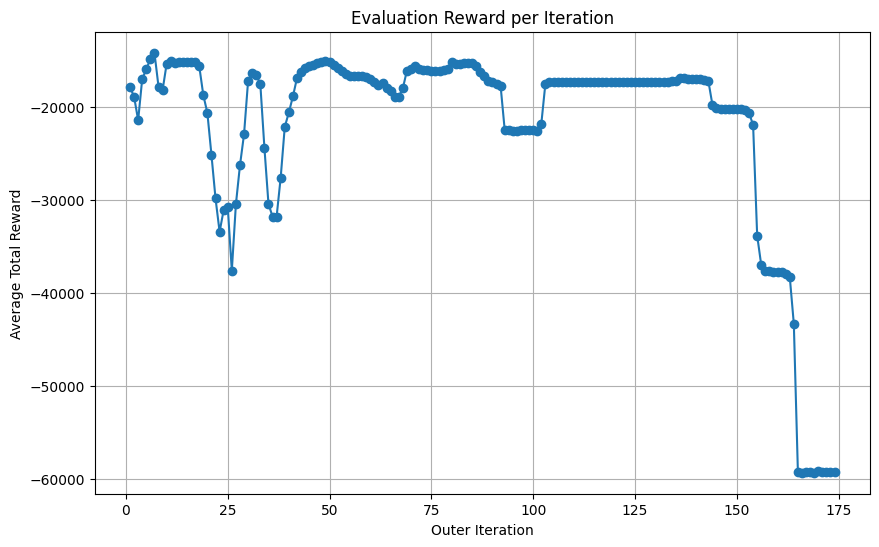

Reward plot saved to results/ms-iclr/sac/lqr_10d_sigma_0p1_u[-5,5]_x[-5,5]_xavierscale=5.0/reward_plot.png


<Figure size 640x480 with 0 Axes>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from time import time
import math
import os
from os import makedirs

# ============================
# 1. 환경 dynamics 정의
# ============================

# 상태-행동 차원 설정
device = "cpu"  # torch.device("cuda" if torch.cuda.is_available() else "cpu")



d, m = 10, 10

# 데이터 로드
from os import path, makedirs

try:
    matrix = np.load("gym_lqr/gym_lqr/envs/data/matrix_10d_10d.npz")
except FileNotFoundError:
    print("Error: matrix_10d_10d.npz not found. Using random matrices.")
    A_np = np.random.randn(d, d)
    B_np = np.random.randn(d, m)


A = torch.from_numpy(matrix['A']).float().to(device)
B = torch.from_numpy(matrix['B']).float().to(device)

# drift 함수: b(x,u) = Ax + uB
def b(x, u):
    # x: [B, d], u: [B, m]
    return x @ A.T + u @ B

# diffusion 함수: constant diagonal noise
def sigma(x, u):
    # 고정된 대각 행렬 (작은 스케일)
    S = 0.01 * torch.eye(d, device=device)
    return S.unsqueeze(0).expand(x.shape[0], d, d)

# reward 함수 (running cost): r(x,u) = -5||x||^2 - ||u||^2
def r(x, u):
    cost_x = 5.0 * torch.sum(x**2, dim=1)
    cost_u = torch.sum(u**2, dim=1)
    return -(cost_x + cost_u)

# 도메인 클리핑
# max_x = 10
max_x = 5
# max_u = 10
max_u = 5
X_min, X_max = X_domain = torch.tensor([[-1 * max_x]*d, [max_x]*d], device=device)
U_min, U_max = U_domain = torch.tensor([[-1 * max_u]*m, [max_u]*m], device=device)

xavier_gain = 5.

# 결과 저장을 위한 디렉토리 생성
results_dir = f"results/ms-iclr/sac/lqr_{m}d_sigma_0p1_u[-{max_u},{max_u}]_x[-{max_x},{max_x}]_xavierscale={xavier_gain}"
makedirs(results_dir, exist_ok=True)


# ============================
# 2. SAC 구성 요소 정의
# ============================

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[256,256]):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)

        if xavier_gain:
            for m in self.model:
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight, gain=xavier_gain)
                    nn.init.zeros_(m.bias)
    
    
    def forward(self, x):
        return self.model(x)

# Actor: state -> Gaussian(mean, log_std)
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256], log_std_min=-20, log_std_max=2):
        super().__init__()
        self.net = MLP(state_dim, 2*action_dim, hidden_dims)
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

    def forward(self, x):
        out = self.net(x)
        mu, log_std = torch.chunk(out, 2, dim=-1)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        std = torch.exp(log_std)
        return mu, std

    def sample(self, x, _eps=1e-9):
        mu, std = self.forward(x)
        eps = torch.randn_like(mu)
        action = mu + eps * std
        action_tanh = U_max[0] * torch.tanh(action)
        log_prob = -0.5 * ((eps**2) + np.log(2*torch.pi))-torch.log((U_max[0] * torch.abs(mu)) + _eps)-torch.log(1-(action_tanh/U_max[0])**2 + _eps)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        # 액션을 도메인에 맞춰 tanh 스케일링
        return action_tanh, log_prob

# Q-network: state, action -> Q-value
class QNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256]):
        super().__init__()
        self.net = MLP(state_dim+action_dim, 1, hidden_dims)

    def forward(self, x, u):
        xu = torch.cat([x, u], dim=-1)
        return self.net(xu)

# Replay buffer
def soft_update(net, target_net, tau):
    for p, tp in zip(net.parameters(), target_net.parameters()):
        tp.data.copy_(tau * p.data + (1 - tau) * tp.data)

class ReplayBuffer:
    def __init__(self, max_size=1_000_000):
        self.buffer = deque(maxlen=max_size)

    def add(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = zip(*batch)
        return (torch.stack(state), torch.stack(action),
                torch.tensor(reward, device=device).unsqueeze(1),
                torch.stack(next_state))


# ============================
# 3. 학습 파라미터 및 네트워크 초기화
# ============================

# 하이퍼파라미터
rho = 0.5
eval_dt= 0.02
tau = eval_dt
gamma = math.exp(-rho * eval_dt)
# gamma = 0.99
alpha = 0.2  # 온도 계수
lr = 3e-4
batch_size = 256
num_steps = 2000
start_steps = 200
update_after = 200
update_every = 1

actor = Actor(d, m).to(device)
q = QNet(d, m).to(device)
q_target = QNet(d, m).to(device)

# 타겟 네트워크 초기화
q_target.load_state_dict(q.state_dict())

# Optimizers
actor_opt = optim.Adam(actor.parameters(), lr=lr)
q_opt = optim.Adam(q.parameters(), lr=lr)

# Replay buffer 생성
replay = ReplayBuffer()

# 초기 상태 샘플링 함수
def sample_initial_state(batch_size=1):
    x0 = torch.zeros(batch_size, d, device=device)
    return x0

# 평가용 하이퍼파라미터\
# rho = 0.5      # 할인율
lam = 0.1      # 엔트로피 가중치
eval_num_traj = 30        # 평가 시뮬레이션 궤적 수
eval_traj_len = 100       # 각 궤적의 길이
# eval_dt = 0.005            # 시뮬레이션 시간 스텝
# gamma = math.exp(-rho * eval_dt) # 스텝마다의 할인율

print(gamma)


@torch.no_grad()
def evaluate_policy(policy_net, num_traj, traj_len, dt):
    print('Start evaluating')
    policy_net.eval() # 평가 모드
    total_rewards = []
    

    # 초기 상태는 0 벡터로 시작
    # x = torch.zeros(num_traj, d, device=device)
    x = 0.1 * torch.ones(num_traj, d, device=device)
    episode_reward = torch.zeros(num_traj, device=device)
    x_norm_hist = torch.zeros(num_traj, traj_len, device = device)
    
    for t in range(traj_len):
        # sample from policy
        #print(f'state shape: {x.shape}')
        u = policy_net.sample(x)[0].squeeze(1) # [num_traj, m]
        #print(u.shape)
        
        # 보상 계산
        current_reward = r(x, u) # [B]
        episode_reward += current_reward * (gamma ** t) # [B]
        
        # 다음 상태 계산 (Euler-Maruyama)
        drift_term = b(x, u) # [num_traj, d]
        diffusion_term = (sigma(x, u) @ torch.randn(num_traj, d, 1, device=device)).squeeze(2)
        #print(f'diffusion term shape: {diffusion_term.shape}')

        #print(x.shape, drift_term.shape, diffusion_term.shape)
        x = x + drift_term * dt + diffusion_term * np.sqrt(dt)
        #x = torch.clamp(x, X_domain[0][0], X_domain[1][0])
        x_norm_hist[:,t] = torch.norm(x, dim=1)

    x_norm_hist = torch.mean(x_norm_hist, dim=0) 
    policy_net.train() # 다시 학습 모드로
    return torch.mean(episode_reward), x_norm_hist


avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)

print(avg_reward)

# ============================
# 4. 메인 학습 루프
# ============================

torch.autograd.set_detect_anomaly(True)
reward_history = []
x_norm_hist_hist = torch.zeros(num_steps, eval_traj_len, device=device)
start = time()
state = sample_initial_state()
for t in range(0, num_steps):
    # 1) 행동 선택
    if t < start_steps:
        action = torch.rand(1, m, device=device) * 2 - 1  # 탐사용 랜덤 액션
    else:
        action, _ = actor.sample(state)

    # 2) 환경 전이 (Euler-Maruyama integration)
    dt = eval_dt
    drift = b(state, action) * dt
    noise = sigma(state, action)
    dW = torch.randn_like(state) * np.sqrt(dt)
    next_state = state + drift + (noise @ dW.unsqueeze(-1)).squeeze(-1)
    # 도메인 클리핑
    next_state = torch.max(torch.min(next_state, X_max), X_min)

    # 3) 보상 계산
    reward = r(state, action)

    # 4) 리플레이 버퍼에 저장
    replay.add((state.squeeze(0).detach(), action.squeeze(0).detach(), reward, next_state.squeeze(0).detach()))
    state = next_state.detach()

    # 5) 네트워크 업데이트
    updated = False
    if t >= update_after and len(replay.buffer) >= batch_size:
        for _ in range(update_every):
            s, u, rew, s2 = replay.sample(batch_size)

            # 타겟 Q 값 계산
            with torch.no_grad():
                a2, logp2 = actor.sample(s2)
                q_t = q_target(s2, a2)
                y = rew + gamma * (q_t - alpha * logp2)

            # Q 함수 업데이트
            q_loss = nn.MSELoss()(q(s, u), y)
            q_opt.zero_grad(); q_loss.backward(); q_opt.step()

            # 정책 업데이트
            a_hat, logp_hat = actor.sample(s)
            q_val = q(s, a_hat)
            actor_loss = (alpha * logp_hat - q_val).mean()
            actor_opt.zero_grad(); actor_loss.backward(); actor_opt.step()

            # 타겟 네트워크 소프트 업데이트
            soft_update(q, q_target, tau)

        updated = True

    # 에피소드 재시작: 상태가 너무 커지면 초기화
    if torch.norm(state) > 10:
        state = sample_initial_state()

    if t % 10 == 0 and updated:
        avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)
        avg_reward = avg_reward.item()
        reward_history.append(avg_reward)
        x_norm_hist_hist[t, :] = x_norm_hist
        print(f"Evaluation Average Reward: {avg_reward:.4e} Time: {time() - start:.2f}s")

    # 로그 출력
    if t % 100 == 0:
        print(f"Step {t}: Reward {reward.item():.3f} ")

print("Training finished.")


# 보상 기록 저장
reward_file = os.path.join(results_dir, "reward_history.npy")
np.save(reward_file, np.array(reward_history))
print(f"Reward history saved to {reward_file}")

reward_file = os.path.join(results_dir, "reward_history.npy")
reward_history = np.load(reward_file)
print("Loaded reward history")

from matplotlib import pyplot as plt

print(len(reward_history))
# reward_history = reward_history[:70]
# 보상 그래프 시각화 및 저장
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(reward_history) + 1), reward_history, marker='o')

plt.title("Evaluation Reward per Iteration")
plt.xlabel("Outer Iteration")
plt.ylabel("Average Total Reward")
plt.grid(True)
plt.yscale('linear')
# plt.yscale('symlog')

plt.show()
plot_file = os.path.join(results_dir, "reward_plot.png")
plt.savefig(plot_file)
print(f"Reward plot saved to {plot_file}")

### x_0 = 0, umax = 5, xmax = 5, xavier scale = None

0.9900498337491681
Start evaluating
tensor(-6546.3013)
Step 0: Reward -2.724 
Step 100: Reward -3.900 
Step 200: Reward -99.462 
Start evaluating
Evaluation Average Reward: -6.4479e+03 Time: 0.92s
Start evaluating
Evaluation Average Reward: -6.2642e+03 Time: 1.51s
Start evaluating
Evaluation Average Reward: -5.8831e+03 Time: 1.95s
Start evaluating
Evaluation Average Reward: -5.6561e+03 Time: 2.41s
Start evaluating
Evaluation Average Reward: -5.2504e+03 Time: 2.90s
Step 300: Reward -107.030 
Start evaluating
Evaluation Average Reward: -4.8174e+03 Time: 3.50s
Start evaluating
Evaluation Average Reward: -4.2116e+03 Time: 4.09s
Start evaluating
Evaluation Average Reward: -3.5376e+03 Time: 4.52s
Start evaluating
Evaluation Average Reward: -2.7218e+03 Time: 5.06s
Start evaluating
Evaluation Average Reward: -2.1966e+03 Time: 5.50s
Start evaluating
Evaluation Average Reward: -1.6923e+03 Time: 5.91s
Start evaluating
Evaluation Average Reward: -1.4165e+03 Time: 6.37s
Start evaluating
Evaluation 

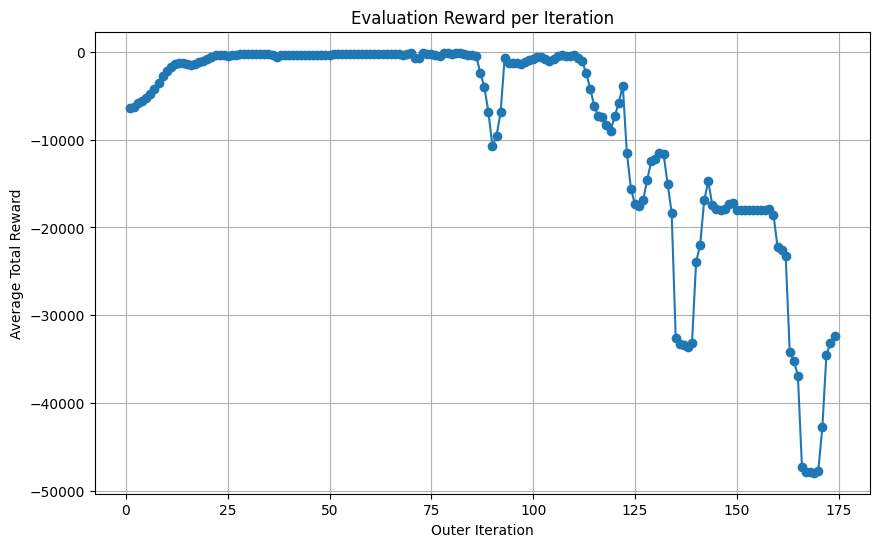

Reward plot saved to results/ms-iclr/sac/lqr_10d_sigma_0p1_u[-5,5]_x[-5,5]_xavierscale=None/reward_plot.png


<Figure size 640x480 with 0 Axes>

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from time import time
import math
import os
from os import makedirs

# ============================
# 1. 환경 dynamics 정의
# ============================

# 상태-행동 차원 설정
device = "cpu"  # torch.device("cuda" if torch.cuda.is_available() else "cpu")



d, m = 10, 10

# 데이터 로드
from os import path, makedirs

try:
    matrix = np.load("gym_lqr/gym_lqr/envs/data/matrix_10d_10d.npz")
except FileNotFoundError:
    print("Error: matrix_10d_10d.npz not found. Using random matrices.")
    A_np = np.random.randn(d, d)
    B_np = np.random.randn(d, m)


A = torch.from_numpy(matrix['A']).float().to(device)
B = torch.from_numpy(matrix['B']).float().to(device)

# drift 함수: b(x,u) = Ax + uB
def b(x, u):
    # x: [B, d], u: [B, m]
    return x @ A.T + u @ B

# diffusion 함수: constant diagonal noise
def sigma(x, u):
    # 고정된 대각 행렬 (작은 스케일)
    S = 0.01 * torch.eye(d, device=device)
    return S.unsqueeze(0).expand(x.shape[0], d, d)

# reward 함수 (running cost): r(x,u) = -5||x||^2 - ||u||^2
def r(x, u):
    cost_x = 5.0 * torch.sum(x**2, dim=1)
    cost_u = torch.sum(u**2, dim=1)
    return -(cost_x + cost_u)

# 도메인 클리핑
# max_x = 10
max_x = 5
# max_u = 10
max_u = 5
X_min, X_max = X_domain = torch.tensor([[-1 * max_x]*d, [max_x]*d], device=device)
U_min, U_max = U_domain = torch.tensor([[-1 * max_u]*m, [max_u]*m], device=device)

xavier_gain = None

# 결과 저장을 위한 디렉토리 생성
results_dir = f"results/ms-iclr/sac/lqr_{m}d_sigma_0p1_u[-{max_u},{max_u}]_x[-{max_x},{max_x}]_xavierscale={xavier_gain}"
makedirs(results_dir, exist_ok=True)


# ============================
# 2. SAC 구성 요소 정의
# ============================

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[256,256]):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)

        if xavier_gain:
            for m in self.model:
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight, gain=xavier_gain)
                    nn.init.zeros_(m.bias)
    
    
    def forward(self, x):
        return self.model(x)

# Actor: state -> Gaussian(mean, log_std)
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256], log_std_min=-20, log_std_max=2):
        super().__init__()
        self.net = MLP(state_dim, 2*action_dim, hidden_dims)
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

    def forward(self, x):
        out = self.net(x)
        mu, log_std = torch.chunk(out, 2, dim=-1)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        std = torch.exp(log_std)
        return mu, std

    def sample(self, x, _eps=1e-9):
        mu, std = self.forward(x)
        eps = torch.randn_like(mu)
        action = mu + eps * std
        action_tanh = U_max[0] * torch.tanh(action)
        log_prob = -0.5 * ((eps**2) + np.log(2*torch.pi))-torch.log((U_max[0] * torch.abs(mu)) + _eps)-torch.log(1-(action_tanh/U_max[0])**2 + _eps)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        # 액션을 도메인에 맞춰 tanh 스케일링
        return action_tanh, log_prob

# Q-network: state, action -> Q-value
class QNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256]):
        super().__init__()
        self.net = MLP(state_dim+action_dim, 1, hidden_dims)

    def forward(self, x, u):
        xu = torch.cat([x, u], dim=-1)
        return self.net(xu)

# Replay buffer
def soft_update(net, target_net, tau):
    for p, tp in zip(net.parameters(), target_net.parameters()):
        tp.data.copy_(tau * p.data + (1 - tau) * tp.data)

class ReplayBuffer:
    def __init__(self, max_size=1_000_000):
        self.buffer = deque(maxlen=max_size)

    def add(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = zip(*batch)
        return (torch.stack(state), torch.stack(action),
                torch.tensor(reward, device=device).unsqueeze(1),
                torch.stack(next_state))


# ============================
# 3. 학습 파라미터 및 네트워크 초기화
# ============================

# 하이퍼파라미터
rho = 0.5
eval_dt= 0.02
tau = eval_dt
gamma = math.exp(-rho * eval_dt)
# gamma = 0.99
alpha = 0.2  # 온도 계수
lr = 3e-4
batch_size = 256
num_steps = 2000
start_steps = 200
update_after = 200
update_every = 1

actor = Actor(d, m).to(device)
q = QNet(d, m).to(device)
q_target = QNet(d, m).to(device)

# 타겟 네트워크 초기화
q_target.load_state_dict(q.state_dict())

# Optimizers
actor_opt = optim.Adam(actor.parameters(), lr=lr)
q_opt = optim.Adam(q.parameters(), lr=lr)

# Replay buffer 생성
replay = ReplayBuffer()

# 초기 상태 샘플링 함수
def sample_initial_state(batch_size=1):
    x0 = torch.zeros(batch_size, d, device=device)
    return x0

# 평가용 하이퍼파라미터\
# rho = 0.5      # 할인율
lam = 0.1      # 엔트로피 가중치
eval_num_traj = 30        # 평가 시뮬레이션 궤적 수
eval_traj_len = 100       # 각 궤적의 길이
# eval_dt = 0.005            # 시뮬레이션 시간 스텝
# gamma = math.exp(-rho * eval_dt) # 스텝마다의 할인율

print(gamma)


@torch.no_grad()
def evaluate_policy(policy_net, num_traj, traj_len, dt):
    print('Start evaluating')
    policy_net.eval() # 평가 모드
    total_rewards = []
    

    # 초기 상태는 0 벡터로 시작
    # x = torch.zeros(num_traj, d, device=device)
    x = 0.1 * torch.ones(num_traj, d, device=device)
    episode_reward = torch.zeros(num_traj, device=device)
    x_norm_hist = torch.zeros(num_traj, traj_len, device = device)
    
    for t in range(traj_len):
        # sample from policy
        #print(f'state shape: {x.shape}')
        u = policy_net.sample(x)[0].squeeze(1) # [num_traj, m]
        #print(u.shape)
        
        # 보상 계산
        current_reward = r(x, u) # [B]
        episode_reward += current_reward * (gamma ** t) # [B]
        
        # 다음 상태 계산 (Euler-Maruyama)
        drift_term = b(x, u) # [num_traj, d]
        diffusion_term = (sigma(x, u) @ torch.randn(num_traj, d, 1, device=device)).squeeze(2)
        #print(f'diffusion term shape: {diffusion_term.shape}')

        #print(x.shape, drift_term.shape, diffusion_term.shape)
        x = x + drift_term * dt + diffusion_term * np.sqrt(dt)
        #x = torch.clamp(x, X_domain[0][0], X_domain[1][0])
        x_norm_hist[:,t] = torch.norm(x, dim=1)

    x_norm_hist = torch.mean(x_norm_hist, dim=0) 
    policy_net.train() # 다시 학습 모드로
    return torch.mean(episode_reward), x_norm_hist


avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)

print(avg_reward)

# ============================
# 4. 메인 학습 루프
# ============================

torch.autograd.set_detect_anomaly(True)
reward_history = []
x_norm_hist_hist = torch.zeros(num_steps, eval_traj_len, device=device)
start = time()
state = sample_initial_state()
for t in range(0, num_steps):
    # 1) 행동 선택
    if t < start_steps:
        action = torch.rand(1, m, device=device) * 2 - 1  # 탐사용 랜덤 액션
    else:
        action, _ = actor.sample(state)

    # 2) 환경 전이 (Euler-Maruyama integration)
    dt = eval_dt
    drift = b(state, action) * dt
    noise = sigma(state, action)
    dW = torch.randn_like(state) * np.sqrt(dt)
    next_state = state + drift + (noise @ dW.unsqueeze(-1)).squeeze(-1)
    # 도메인 클리핑
    next_state = torch.max(torch.min(next_state, X_max), X_min)

    # 3) 보상 계산
    reward = r(state, action)

    # 4) 리플레이 버퍼에 저장
    replay.add((state.squeeze(0).detach(), action.squeeze(0).detach(), reward, next_state.squeeze(0).detach()))
    state = next_state.detach()

    # 5) 네트워크 업데이트
    updated = False
    if t >= update_after and len(replay.buffer) >= batch_size:
        for _ in range(update_every):
            s, u, rew, s2 = replay.sample(batch_size)

            # 타겟 Q 값 계산
            with torch.no_grad():
                a2, logp2 = actor.sample(s2)
                q_t = q_target(s2, a2)
                y = rew + gamma * (q_t - alpha * logp2)

            # Q 함수 업데이트
            q_loss = nn.MSELoss()(q(s, u), y)
            q_opt.zero_grad(); q_loss.backward(); q_opt.step()

            # 정책 업데이트
            a_hat, logp_hat = actor.sample(s)
            q_val = q(s, a_hat)
            actor_loss = (alpha * logp_hat - q_val).mean()
            actor_opt.zero_grad(); actor_loss.backward(); actor_opt.step()

            # 타겟 네트워크 소프트 업데이트
            soft_update(q, q_target, tau)

        updated = True

    # 에피소드 재시작: 상태가 너무 커지면 초기화
    if torch.norm(state) > 10:
        state = sample_initial_state()

    if t % 10 == 0 and updated:
        avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)
        avg_reward = avg_reward.item()
        reward_history.append(avg_reward)
        x_norm_hist_hist[t, :] = x_norm_hist
        print(f"Evaluation Average Reward: {avg_reward:.4e} Time: {time() - start:.2f}s")

    # 로그 출력
    if t % 100 == 0:
        print(f"Step {t}: Reward {reward.item():.3f} ")

print("Training finished.")


# 보상 기록 저장
reward_file = os.path.join(results_dir, "reward_history.npy")
np.save(reward_file, np.array(reward_history))
print(f"Reward history saved to {reward_file}")

reward_file = os.path.join(results_dir, "reward_history.npy")
reward_history = np.load(reward_file)
print("Loaded reward history")

from matplotlib import pyplot as plt

print(len(reward_history))
# reward_history = reward_history[:70]
# 보상 그래프 시각화 및 저장
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(reward_history) + 1), reward_history, marker='o')

plt.title("Evaluation Reward per Iteration")
plt.xlabel("Outer Iteration")
plt.ylabel("Average Total Reward")
plt.grid(True)
plt.yscale('linear')
# plt.yscale('symlog')

plt.show()
plot_file = os.path.join(results_dir, "reward_plot.png")
plt.savefig(plot_file)
print(f"Reward plot saved to {plot_file}")

### x_0 = 0, umax = 10, xmax = 10, xavier scale = None

0.9900498337491681
Start evaluating
tensor(-26460.0918)
Step 0: Reward -2.292 
Step 100: Reward -4.810 
Step 200: Reward -359.231 
Start evaluating
Evaluation Average Reward: -2.5626e+04 Time: 0.62s
Start evaluating
Evaluation Average Reward: -2.4748e+04 Time: 0.94s
Start evaluating
Evaluation Average Reward: -2.3713e+04 Time: 1.27s
Start evaluating
Evaluation Average Reward: -2.2367e+04 Time: 1.59s
Start evaluating
Evaluation Average Reward: -2.0382e+04 Time: 1.91s
Step 300: Reward -385.075 
Start evaluating
Evaluation Average Reward: -1.7208e+04 Time: 2.24s
Start evaluating
Evaluation Average Reward: -1.4273e+04 Time: 2.55s
Start evaluating
Evaluation Average Reward: -1.1680e+04 Time: 2.85s
Start evaluating
Evaluation Average Reward: -9.6522e+03 Time: 3.16s
Start evaluating
Evaluation Average Reward: -6.9924e+03 Time: 3.47s
Start evaluating
Evaluation Average Reward: -6.5730e+03 Time: 3.79s
Start evaluating
Evaluation Average Reward: -9.0910e+03 Time: 4.11s
Start evaluating
Evaluatio

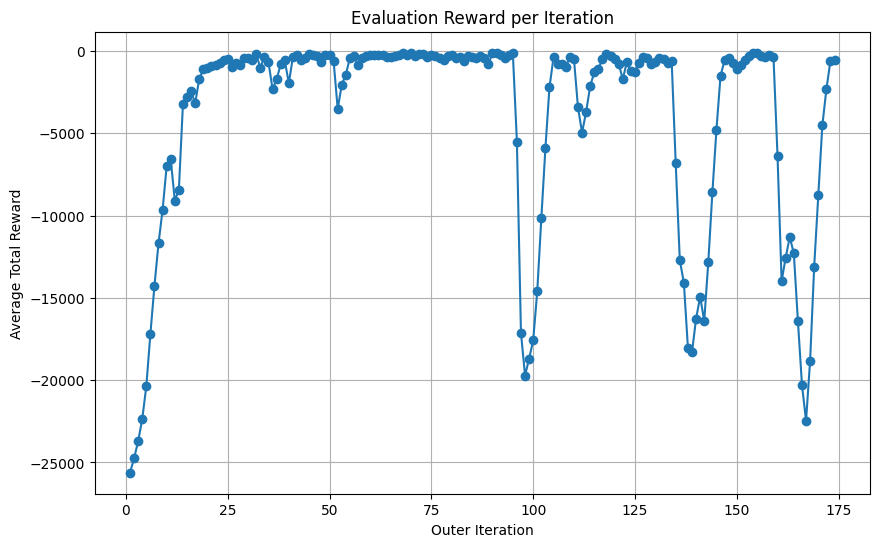

Reward plot saved to results/ms-iclr/sac/lqr_10d_sigma_0p1_u[-10,10]_x[-10,10]_xavierscale=5/reward_plot.png


<Figure size 640x480 with 0 Axes>

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from time import time
import math
import os
from os import makedirs

# ============================
# 1. 환경 dynamics 정의
# ============================

# 상태-행동 차원 설정
device = "cpu"  # torch.device("cuda" if torch.cuda.is_available() else "cpu")

d, m = 10, 10

# 데이터 로드
from os import path, makedirs

try:
    matrix = np.load("gym_lqr/gym_lqr/envs/data/matrix_10d_10d.npz")
except FileNotFoundError:
    print("Error: matrix_10d_10d.npz not found. Using random matrices.")
    A_np = np.random.randn(d, d)
    B_np = np.random.randn(d, m)


A = torch.from_numpy(matrix['A']).float().to(device)
B = torch.from_numpy(matrix['B']).float().to(device)

# drift 함수: b(x,u) = Ax + uB
def b(x, u):
    # x: [B, d], u: [B, m]
    return x @ A.T + u @ B

# diffusion 함수: constant diagonal noise
def sigma(x, u):
    # 고정된 대각 행렬 (작은 스케일)
    S = 0.01 * torch.eye(d, device=device)
    return S.unsqueeze(0).expand(x.shape[0], d, d)

# reward 함수 (running cost): r(x,u) = -5||x||^2 - ||u||^2
def r(x, u):
    cost_x = 5.0 * torch.sum(x**2, dim=1)
    cost_u = torch.sum(u**2, dim=1)
    return -(cost_x + cost_u)

# 도메인 클리핑
# max_x = 10
max_x = 10
# max_u = 10
max_u = 10
X_min, X_max = X_domain = torch.tensor([[-1 * max_x]*d, [max_x]*d], device=device)
U_min, U_max = U_domain = torch.tensor([[-1 * max_u]*m, [max_u]*m], device=device)


# ============================
# 2. SAC 구성 요소 정의
# ============================

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[256,256]):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Actor: state -> Gaussian(mean, log_std)
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256], log_std_min=-20, log_std_max=2):
        super().__init__()
        self.net = MLP(state_dim, 2*action_dim, hidden_dims)
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

    def forward(self, x):
        out = self.net(x)
        mu, log_std = torch.chunk(out, 2, dim=-1)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        std = torch.exp(log_std)
        return mu, std

    def sample(self, x, _eps=1e-9):
        mu, std = self.forward(x)
        eps = torch.randn_like(mu)
        action = mu + eps * std
        action_tanh = U_max[0] * torch.tanh(action)
        log_prob = -0.5 * ((eps**2) + np.log(2*torch.pi))-torch.log((U_max[0] * torch.abs(mu)) + _eps)-torch.log(1-(action_tanh/U_max[0])**2 + _eps)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        # 액션을 도메인에 맞춰 tanh 스케일링
        return action_tanh, log_prob

# Q-network: state, action -> Q-value
class QNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256]):
        super().__init__()
        self.net = MLP(state_dim+action_dim, 1, hidden_dims)

    def forward(self, x, u):
        xu = torch.cat([x, u], dim=-1)
        return self.net(xu)

# Replay buffer
def soft_update(net, target_net, tau):
    for p, tp in zip(net.parameters(), target_net.parameters()):
        tp.data.copy_(tau * p.data + (1 - tau) * tp.data)

class ReplayBuffer:
    def __init__(self, max_size=1_000_000):
        self.buffer = deque(maxlen=max_size)

    def add(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = zip(*batch)
        return (torch.stack(state), torch.stack(action),
                torch.tensor(reward, device=device).unsqueeze(1),
                torch.stack(next_state))


# ============================
# 3. 학습 파라미터 및 네트워크 초기화
# ============================

# 하이퍼파라미터
rho = 0.5
eval_dt= 0.02
tau = eval_dt
gamma = math.exp(-rho * eval_dt)
# gamma = 0.99
alpha = 0.2  # 온도 계수
lr = 3e-4
batch_size = 256
num_steps = 2000
start_steps = 200
update_after = 200
update_every = 1

actor = Actor(d, m).to(device)
q = QNet(d, m).to(device)
q_target = QNet(d, m).to(device)

# 타겟 네트워크 초기화
q_target.load_state_dict(q.state_dict())

# Optimizers
actor_opt = optim.Adam(actor.parameters(), lr=lr)
q_opt = optim.Adam(q.parameters(), lr=lr)

# Replay buffer 생성
replay = ReplayBuffer()

# 초기 상태 샘플링 함수
def sample_initial_state(batch_size=1):
    x0 = torch.zeros(batch_size, d, device=device)
    return x0

# 평가용 하이퍼파라미터\
# rho = 0.5      # 할인율
lam = 0.1      # 엔트로피 가중치
eval_num_traj = 30        # 평가 시뮬레이션 궤적 수
eval_traj_len = 100       # 각 궤적의 길이
# eval_dt = 0.005            # 시뮬레이션 시간 스텝
# gamma = math.exp(-rho * eval_dt) # 스텝마다의 할인율

print(gamma)

xavier_gain = None

# 결과 저장을 위한 디렉토리 생성
results_dir = f"results/ms-iclr/sac/lqr_{m}d_sigma_0p1_u[-{max_u},{max_u}]_x[-{max_x},{max_x}]_xavierscale={xavier_gain}"
makedirs(results_dir, exist_ok=True)



@torch.no_grad()
def evaluate_policy(policy_net, num_traj, traj_len, dt):
    print('Start evaluating')
    policy_net.eval() # 평가 모드
    total_rewards = []
    

    # 초기 상태는 0 벡터로 시작
    # x = torch.zeros(num_traj, d, device=device)
    x = 0.1 * torch.ones(num_traj, d, device=device)
    episode_reward = torch.zeros(num_traj, device=device)
    x_norm_hist = torch.zeros(num_traj, traj_len, device = device)
    
    for t in range(traj_len):
        # sample from policy
        #print(f'state shape: {x.shape}')
        u = policy_net.sample(x)[0].squeeze(1) # [num_traj, m]
        #print(u.shape)
        
        # 보상 계산
        current_reward = r(x, u) # [B]
        episode_reward += current_reward * (gamma ** t) # [B]
        
        # 다음 상태 계산 (Euler-Maruyama)
        drift_term = b(x, u) # [num_traj, d]
        diffusion_term = (sigma(x, u) @ torch.randn(num_traj, d, 1, device=device)).squeeze(2)
        #print(f'diffusion term shape: {diffusion_term.shape}')

        #print(x.shape, drift_term.shape, diffusion_term.shape)
        x = x + drift_term * dt + diffusion_term * np.sqrt(dt)
        #x = torch.clamp(x, X_domain[0][0], X_domain[1][0])
        x_norm_hist[:,t] = torch.norm(x, dim=1)

    x_norm_hist = torch.mean(x_norm_hist, dim=0) 
    policy_net.train() # 다시 학습 모드로
    return torch.mean(episode_reward), x_norm_hist


avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)

print(avg_reward)

# ============================
# 4. 메인 학습 루프
# ============================

torch.autograd.set_detect_anomaly(True)
reward_history = []
x_norm_hist_hist = torch.zeros(num_steps, eval_traj_len, device=device)
start = time()
state = sample_initial_state()
for t in range(0, num_steps):
    # 1) 행동 선택
    if t < start_steps:
        action = torch.rand(1, m, device=device) * 2 - 1  # 탐사용 랜덤 액션
    else:
        action, _ = actor.sample(state)

    # 2) 환경 전이 (Euler-Maruyama integration)
    dt = eval_dt
    drift = b(state, action) * dt
    noise = sigma(state, action)
    dW = torch.randn_like(state) * np.sqrt(dt)
    next_state = state + drift + (noise @ dW.unsqueeze(-1)).squeeze(-1)
    # 도메인 클리핑
    next_state = torch.max(torch.min(next_state, X_max), X_min)

    # 3) 보상 계산
    reward = r(state, action)

    # 4) 리플레이 버퍼에 저장
    replay.add((state.squeeze(0).detach(), action.squeeze(0).detach(), reward, next_state.squeeze(0).detach()))
    state = next_state.detach()

    # 5) 네트워크 업데이트
    updated = False
    if t >= update_after and len(replay.buffer) >= batch_size:
        for _ in range(update_every):
            s, u, rew, s2 = replay.sample(batch_size)

            # 타겟 Q 값 계산
            with torch.no_grad():
                a2, logp2 = actor.sample(s2)
                q_t = q_target(s2, a2)
                y = rew + gamma * (q_t - alpha * logp2)

            # Q 함수 업데이트
            q_loss = nn.MSELoss()(q(s, u), y)
            q_opt.zero_grad(); q_loss.backward(); q_opt.step()

            # 정책 업데이트
            a_hat, logp_hat = actor.sample(s)
            q_val = q(s, a_hat)
            actor_loss = (alpha * logp_hat - q_val).mean()
            actor_opt.zero_grad(); actor_loss.backward(); actor_opt.step()

            # 타겟 네트워크 소프트 업데이트
            soft_update(q, q_target, tau)

        updated = True

    # 에피소드 재시작: 상태가 너무 커지면 초기화
    if torch.norm(state) > 10:
        state = sample_initial_state()

    if t % 10 == 0 and updated:
        avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)
        avg_reward = avg_reward.item()
        reward_history.append(avg_reward)
        x_norm_hist_hist[t, :] = x_norm_hist
        print(f"Evaluation Average Reward: {avg_reward:.4e} Time: {time() - start:.2f}s")

    # 로그 출력
    if t % 100 == 0:
        print(f"Step {t}: Reward {reward.item():.3f} ")

print("Training finished.")


# 보상 기록 저장
reward_file = os.path.join(results_dir, "reward_history.npy")
np.save(reward_file, np.array(reward_history))
print(f"Reward history saved to {reward_file}")

reward_file = os.path.join(results_dir, "reward_history.npy")
reward_history = np.load(reward_file)
print("Loaded reward history")

from matplotlib import pyplot as plt

print(len(reward_history))
# reward_history = reward_history[:70]
# 보상 그래프 시각화 및 저장
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(reward_history) + 1), reward_history, marker='o')

plt.title("Evaluation Reward per Iteration")
plt.xlabel("Outer Iteration")
plt.ylabel("Average Total Reward")
plt.grid(True)
plt.yscale('linear')
# plt.yscale('symlog')

plt.show()
plot_file = os.path.join(results_dir, "reward_plot.png")
plt.savefig(plot_file)
print(f"Reward plot saved to {plot_file}")

### new

0.9900498337491681
Start evaluating
tensor(-602.3906)
Step 0: Reward -2.548 
Step 100: Reward -1.838 
Step 200: Reward -5.160 
Start evaluating
Evaluation Average Reward: -6.0941e+02 Time: 0.95s
Start evaluating
Evaluation Average Reward: -6.2769e+02 Time: 1.45s
Start evaluating
Evaluation Average Reward: -7.0560e+02 Time: 1.90s
Start evaluating
Evaluation Average Reward: -8.2110e+02 Time: 2.33s
Start evaluating
Evaluation Average Reward: -9.3606e+02 Time: 2.78s
Step 300: Reward -55.826 
Start evaluating
Evaluation Average Reward: -9.6923e+02 Time: 3.18s
Start evaluating
Evaluation Average Reward: -8.1722e+02 Time: 3.63s
Start evaluating
Evaluation Average Reward: -6.4052e+02 Time: 4.17s
Start evaluating
Evaluation Average Reward: -5.6339e+02 Time: 4.79s
Start evaluating
Evaluation Average Reward: -4.6780e+02 Time: 5.24s
Start evaluating
Evaluation Average Reward: -4.1515e+02 Time: 5.68s
Start evaluating
Evaluation Average Reward: -3.6938e+02 Time: 6.28s
Start evaluating
Evaluation Ave

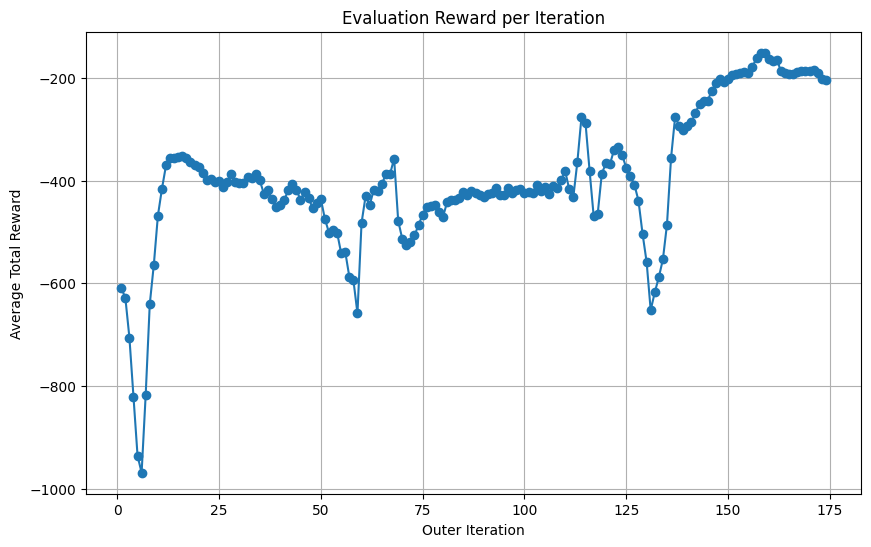

Reward plot saved to results/ms-iclr/sac/lqr_10d_sigma_0p1_u[-1,1]_x[-1,1]_xavierscale=5/reward_plot.png


<Figure size 640x480 with 0 Axes>

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from time import time
import math
import os
from os import makedirs

# ============================
# 1. 환경 dynamics 정의
# ============================

# 상태-행동 차원 설정
device = "cpu"  # torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 결과 저장을 위한 디렉토리 생성
results_dir = "results/ms-iclr/sac/lqr_10d_sigma_0p1_u[-1,1]_x[-1,1]_xavierscale=5"
makedirs(results_dir, exist_ok=True)


d, m = 10, 10

# 데이터 로드
from os import path, makedirs

try:
    matrix = np.load("gym_lqr/gym_lqr/envs/data/matrix_10d_10d.npz")
except FileNotFoundError:
    print("Error: matrix_10d_10d.npz not found. Using random matrices.")
    A_np = np.random.randn(d, d)
    B_np = np.random.randn(d, m)


A = torch.from_numpy(matrix['A']).float().to(device)
B = torch.from_numpy(matrix['B']).float().to(device)

# drift 함수: b(x,u) = Ax + uB
def b(x, u):
    # x: [B, d], u: [B, m]
    return x @ A.T + u @ B

# diffusion 함수: constant diagonal noise
def sigma(x, u):
    # 고정된 대각 행렬 (작은 스케일)
    S = 0.01 * torch.eye(d, device=device)
    return S.unsqueeze(0).expand(x.shape[0], d, d)

# reward 함수 (running cost): r(x,u) = -5||x||^2 - ||u||^2
def r(x, u):
    cost_x = 5.0 * torch.sum(x**2, dim=1)
    cost_u = torch.sum(u**2, dim=1)
    return -(cost_x + cost_u)

# 도메인 클리핑
# max_x = 10
max_x = 1
# max_u = 10
max_u = 1
X_min, X_max = X_domain = torch.tensor([[-1 * max_x]*d, [max_x]*d], device=device)
U_min, U_max = U_domain = torch.tensor([[-1 * max_u]*m, [max_u]*m], device=device)


# ============================
# 2. SAC 구성 요소 정의
# ============================

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[256,256]):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Actor: state -> Gaussian(mean, log_std)
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256], log_std_min=-20, log_std_max=2):
        super().__init__()
        self.net = MLP(state_dim, 2*action_dim, hidden_dims)
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

    def forward(self, x):
        out = self.net(x)
        mu, log_std = torch.chunk(out, 2, dim=-1)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        std = torch.exp(log_std)
        return mu, std

    def sample(self, x, _eps=1e-9):
        mu, std = self.forward(x)
        eps = torch.randn_like(mu)
        action = mu + eps * std
        action_tanh = U_max[0] * torch.tanh(action)
        log_prob = -0.5 * ((eps**2) + np.log(2*torch.pi))-torch.log((U_max[0] * torch.abs(mu)) + _eps)-torch.log(1-(action_tanh/U_max[0])**2 + _eps)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        # 액션을 도메인에 맞춰 tanh 스케일링
        return action_tanh, log_prob

# Q-network: state, action -> Q-value
class QNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256]):
        super().__init__()
        self.net = MLP(state_dim+action_dim, 1, hidden_dims)

    def forward(self, x, u):
        xu = torch.cat([x, u], dim=-1)
        return self.net(xu)

# Replay buffer
def soft_update(net, target_net, tau):
    for p, tp in zip(net.parameters(), target_net.parameters()):
        tp.data.copy_(tau * p.data + (1 - tau) * tp.data)

class ReplayBuffer:
    def __init__(self, max_size=1_000_000):
        self.buffer = deque(maxlen=max_size)

    def add(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = zip(*batch)
        return (torch.stack(state), torch.stack(action),
                torch.tensor(reward, device=device).unsqueeze(1),
                torch.stack(next_state))


# ============================
# 3. 학습 파라미터 및 네트워크 초기화
# ============================

# 하이퍼파라미터
rho = 0.5
eval_dt= 0.02
tau = eval_dt
gamma = math.exp(-rho * eval_dt)
# gamma = 0.99
alpha = 0.2  # 온도 계수
lr = 3e-4
batch_size = 256
num_steps = 2000
start_steps = 200
update_after = 200
update_every = 1

actor = Actor(d, m).to(device)
q = QNet(d, m).to(device)
q_target = QNet(d, m).to(device)

# 타겟 네트워크 초기화
q_target.load_state_dict(q.state_dict())

# Optimizers
actor_opt = optim.Adam(actor.parameters(), lr=lr)
q_opt = optim.Adam(q.parameters(), lr=lr)

# Replay buffer 생성
replay = ReplayBuffer()

# 초기 상태 샘플링 함수
def sample_initial_state(batch_size=1):
    x0 = torch.zeros(batch_size, d, device=device)
    return x0

# 평가용 하이퍼파라미터\
# rho = 0.5      # 할인율
lam = 0.1      # 엔트로피 가중치
eval_num_traj = 30        # 평가 시뮬레이션 궤적 수
eval_traj_len = 100       # 각 궤적의 길이
# eval_dt = 0.005            # 시뮬레이션 시간 스텝
# gamma = math.exp(-rho * eval_dt) # 스텝마다의 할인율

print(gamma)


@torch.no_grad()
def evaluate_policy(policy_net, num_traj, traj_len, dt):
    print('Start evaluating')
    policy_net.eval() # 평가 모드
    total_rewards = []
    

    # 초기 상태는 0 벡터로 시작
    # x = torch.zeros(num_traj, d, device=device)
    x = 0.1 * torch.ones(num_traj, d, device=device)
    episode_reward = torch.zeros(num_traj, device=device)
    x_norm_hist = torch.zeros(num_traj, traj_len, device = device)
    
    for t in range(traj_len):
        # sample from policy
        #print(f'state shape: {x.shape}')
        u = policy_net.sample(x)[0].squeeze(1) # [num_traj, m]
        #print(u.shape)
        
        # 보상 계산
        current_reward = r(x, u) # [B]
        episode_reward += current_reward * (gamma ** t) # [B]
        
        # 다음 상태 계산 (Euler-Maruyama)
        drift_term = b(x, u) # [num_traj, d]
        diffusion_term = (sigma(x, u) @ torch.randn(num_traj, d, 1, device=device)).squeeze(2)
        #print(f'diffusion term shape: {diffusion_term.shape}')

        #print(x.shape, drift_term.shape, diffusion_term.shape)
        x = x + drift_term * dt + diffusion_term * np.sqrt(dt)
        #x = torch.clamp(x, X_domain[0][0], X_domain[1][0])
        x_norm_hist[:,t] = torch.norm(x, dim=1)

    x_norm_hist = torch.mean(x_norm_hist, dim=0) 
    policy_net.train() # 다시 학습 모드로
    return torch.mean(episode_reward), x_norm_hist


avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)

print(avg_reward)

# ============================
# 4. 메인 학습 루프
# ============================

torch.autograd.set_detect_anomaly(True)
reward_history = []
x_norm_hist_hist = torch.zeros(num_steps, eval_traj_len, device=device)
start = time()
state = sample_initial_state()
for t in range(0, num_steps):
    # 1) 행동 선택
    if t < start_steps:
        action = torch.rand(1, m, device=device) * 2 - 1  # 탐사용 랜덤 액션
    else:
        action, _ = actor.sample(state)

    # 2) 환경 전이 (Euler-Maruyama integration)
    dt = eval_dt
    drift = b(state, action) * dt
    noise = sigma(state, action)
    dW = torch.randn_like(state) * np.sqrt(dt)
    next_state = state + drift + (noise @ dW.unsqueeze(-1)).squeeze(-1)
    # 도메인 클리핑
    next_state = torch.max(torch.min(next_state, X_max), X_min)

    # 3) 보상 계산
    reward = r(state, action)

    # 4) 리플레이 버퍼에 저장
    replay.add((state.squeeze(0).detach(), action.squeeze(0).detach(), reward, next_state.squeeze(0).detach()))
    state = next_state.detach()

    # 5) 네트워크 업데이트
    updated = False
    if t >= update_after and len(replay.buffer) >= batch_size:
        for _ in range(update_every):
            s, u, rew, s2 = replay.sample(batch_size)

            # 타겟 Q 값 계산
            with torch.no_grad():
                a2, logp2 = actor.sample(s2)
                q_t = q_target(s2, a2)
                y = rew + gamma * (q_t - alpha * logp2)

            # Q 함수 업데이트
            q_loss = nn.MSELoss()(q(s, u), y)
            q_opt.zero_grad(); q_loss.backward(); q_opt.step()

            # 정책 업데이트
            a_hat, logp_hat = actor.sample(s)
            q_val = q(s, a_hat)
            actor_loss = (alpha * logp_hat - q_val).mean()
            actor_opt.zero_grad(); actor_loss.backward(); actor_opt.step()

            # 타겟 네트워크 소프트 업데이트
            soft_update(q, q_target, tau)

        updated = True

    # 에피소드 재시작: 상태가 너무 커지면 초기화
    if torch.norm(state) > 10:
        state = sample_initial_state()

    if t % 10 == 0 and updated:
        avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)
        avg_reward = avg_reward.item()
        reward_history.append(avg_reward)
        x_norm_hist_hist[t, :] = x_norm_hist
        print(f"Evaluation Average Reward: {avg_reward:.4e} Time: {time() - start:.2f}s")

    # 로그 출력
    if t % 100 == 0:
        print(f"Step {t}: Reward {reward.item():.3f} ")

print("Training finished.")


# 보상 기록 저장
reward_file = os.path.join(results_dir, "reward_history.npy")
np.save(reward_file, np.array(reward_history))
print(f"Reward history saved to {reward_file}")

reward_file = os.path.join(results_dir, "reward_history.npy")
reward_history = np.load(reward_file)
print("Loaded reward history")

from matplotlib import pyplot as plt

print(len(reward_history))
# reward_history = reward_history[:70]
# 보상 그래프 시각화 및 저장
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(reward_history) + 1), reward_history, marker='o')

plt.title("Evaluation Reward per Iteration")
plt.xlabel("Outer Iteration")
plt.ylabel("Average Total Reward")
plt.grid(True)
plt.yscale('linear')
# plt.yscale('symlog')

plt.show()
plot_file = os.path.join(results_dir, "reward_plot.png")
plt.savefig(plot_file)
print(f"Reward plot saved to {plot_file}")

### old

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from time import time
import math
import os
from os import makedirs

In [2]:
# ============================
# 1. 환경 dynamics 정의
# ============================

# 상태-행동 차원 설정
d = 10  # 상태 차원
m = 10  # 행동 차원

device = "cpu"  # torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 결과 저장을 위한 디렉토리 생성
results_dir = "results/ms-iclr/sac/lqr_10d_update_every"
makedirs(results_dir, exist_ok=True)

# 데이터 로드
try:
    matrix = np.load("gym_lqr/gym_lqr/envs/data/matrix_10d_10d.npz")
    A_np, B_np = matrix["A"], matrix["B"]
except FileNotFoundError:
    print("Error: matrix_10d_10d.npz not found. Using random matrices.")
    A_np = np.random.randn(d, d)
    B_np = np.random.randn(d, m)

A = torch.from_numpy(A_np).float().to(device)
B = torch.from_numpy(B_np).float().to(device)

# drift 함수: b(x,u) = Ax + uB
def b(x, u):
    # x: [B, d], u: [B, m]
    return x @ A.T + u @ B

# diffusion 함수: constant diagonal noise
def sigma(x, u):
    # 고정된 대각 행렬 (작은 스케일)
    S = 0.01 * torch.eye(d, device=device)
    return S.unsqueeze(0).expand(x.shape[0], d, d)

# reward 함수 (running cost): r(x,u) = -5||x||^2 - ||u||^2
def r(x, u):
    cost_x = 5.0 * torch.sum(x**2, dim=1)
    cost_u = torch.sum(u**2, dim=1)
    return -(cost_x + cost_u)

# 도메인 클리핑
X_min, X_max = X_domain = torch.tensor([[-10.0]*d, [10.0]*d], device=device)
U_min, U_max = U_domain = torch.tensor([[-10.0]*m, [10.0]*m], device=device)


In [3]:
# ============================
# 2. SAC 구성 요소 정의
# ============================

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[256,256]):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Actor: state -> Gaussian(mean, log_std)
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256], log_std_min=-20, log_std_max=2):
        super().__init__()
        self.net = MLP(state_dim, 2*action_dim, hidden_dims)
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

    def forward(self, x):
        out = self.net(x)
        mu, log_std = torch.chunk(out, 2, dim=-1)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        std = torch.exp(log_std)
        return mu, std

    def sample(self, x, _eps=1e-9):
        mu, std = self.forward(x)
        eps = torch.randn_like(mu)
        action = mu + eps * std
        action_tanh = U_max[0] * torch.tanh(action)
        log_prob = -0.5 * ((eps**2) + np.log(2*torch.pi))-torch.log((U_max[0] * torch.abs(mu)) + _eps)-torch.log(1-(action_tanh/U_max[0])**2 + _eps)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        # 액션을 도메인에 맞춰 tanh 스케일링
        return action_tanh, log_prob

# Q-network: state, action -> Q-value
class QNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256]):
        super().__init__()
        self.net = MLP(state_dim+action_dim, 1, hidden_dims)

    def forward(self, x, u):
        xu = torch.cat([x, u], dim=-1)
        return self.net(xu)

# Replay buffer
def soft_update(net, target_net, tau):
    for p, tp in zip(net.parameters(), target_net.parameters()):
        tp.data.copy_(tau * p.data + (1 - tau) * tp.data)

class ReplayBuffer:
    def __init__(self, max_size=1_000_000):
        self.buffer = deque(maxlen=max_size)

    def add(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = zip(*batch)
        return (torch.stack(state), torch.stack(action),
                torch.tensor(reward, device=device).unsqueeze(1),
                torch.stack(next_state))

In [4]:
# ============================
# 3. 학습 파라미터 및 네트워크 초기화
# ============================

# 하이퍼파라미터
rho = 0.5
eval_dt= 0.02
tau = eval_dt
gamma = math.exp(-rho * eval_dt)

alpha = 0.2  # 온도 계수
lr = 3e-4
batch_size = 256
num_steps = 2000
start_steps = 200
update_after = 200
update_every = 1

actor = Actor(d, m).to(device)
q = QNet(d, m).to(device)
q_target = QNet(d, m).to(device)

# 타겟 네트워크 초기화
q_target.load_state_dict(q.state_dict())

# Optimizers
actor_opt = optim.Adam(actor.parameters(), lr=lr)
q_opt = optim.Adam(q.parameters(), lr=lr)

# Replay buffer 생성
replay = ReplayBuffer()

# 초기 상태 샘플링 함수
def sample_initial_state(batch_size=1):
    x0 = torch.zeros(batch_size, d, device=device)
    return x0

# 평가용 하이퍼파라미터\
# rho = 0.5      # 할인율
lam = 0.1      # 엔트로피 가중치
eval_num_traj = 30        # 평가 시뮬레이션 궤적 수
eval_traj_len = 100       # 각 궤적의 길이
# eval_dt = 0.005            # 시뮬레이션 시간 스텝
# gamma = math.exp(-rho * eval_dt) # 스텝마다의 할인율

print(gamma)

0.9900498337491681


In [5]:
@torch.no_grad()
def evaluate_policy(policy_net, num_traj, traj_len, dt):
    print('Start evaluating')
    policy_net.eval() # 평가 모드
    total_rewards = []
    

    # 초기 상태는 0 벡터로 시작
    x = torch.zeros(num_traj, d, device=device)
    episode_reward = torch.zeros(num_traj, device=device)
    x_norm_hist = torch.zeros(num_traj, traj_len, device = device)
    
    for t in range(traj_len):
        # sample from policy
        #print(f'state shape: {x.shape}')
        u = policy_net.sample(x)[0].squeeze(1) # [num_traj, m]
        #print(u.shape)
        
        # 보상 계산
        current_reward = r(x, u) # [B]
        episode_reward += current_reward * (gamma ** t) # [B]
        
        # 다음 상태 계산 (Euler-Maruyama)
        drift_term = b(x, u) # [num_traj, d]
        diffusion_term = (sigma(x, u) @ torch.randn(num_traj, d, 1, device=device)).squeeze(2)
        #print(f'diffusion term shape: {diffusion_term.shape}')

        #print(x.shape, drift_term.shape, diffusion_term.shape)
        x = x + drift_term * dt + diffusion_term * np.sqrt(dt)
        #x = torch.clamp(x, X_domain[0][0], X_domain[1][0])
        x_norm_hist[:,t] = torch.norm(x, dim=1)

    x_norm_hist = torch.mean(x_norm_hist, dim=0) 
    policy_net.train() # 다시 학습 모드로
    return torch.mean(episode_reward), x_norm_hist

In [6]:
# ============================
# 4. 메인 학습 루프
# ============================

torch.autograd.set_detect_anomaly(True)
reward_history = []
x_norm_hist_hist = torch.zeros(num_steps, eval_traj_len, device=device)
start = time()
state = sample_initial_state()
for t in range(0, num_steps):
    # 1) 행동 선택
    if t < start_steps:
        action = torch.rand(1, m, device=device) * 2 - 1  # 탐사용 랜덤 액션
    else:
        action, _ = actor.sample(state)

    # 2) 환경 전이 (Euler-Maruyama integration)
    dt = eval_dt
    drift = b(state, action) * dt
    noise = sigma(state, action)
    dW = torch.randn_like(state) * np.sqrt(dt)
    next_state = state + drift + (noise @ dW.unsqueeze(-1)).squeeze(-1)
    # 도메인 클리핑
    next_state = torch.max(torch.min(next_state, X_max), X_min)

    # 3) 보상 계산
    reward = r(state, action)

    # 4) 리플레이 버퍼에 저장
    replay.add((state.squeeze(0).detach(), action.squeeze(0).detach(), reward, next_state.squeeze(0).detach()))
    state = next_state.detach()

    # 5) 네트워크 업데이트
    updated = False
    if t >= update_after and len(replay.buffer) >= batch_size:
        for _ in range(update_every):
            s, u, rew, s2 = replay.sample(batch_size)

            # 타겟 Q 값 계산
            with torch.no_grad():
                a2, logp2 = actor.sample(s2)
                q_t = q_target(s2, a2)
                y = rew + gamma * (q_t - alpha * logp2)

            # Q 함수 업데이트
            q_loss = nn.MSELoss()(q(s, u), y)
            q_opt.zero_grad(); q_loss.backward(); q_opt.step()

            # 정책 업데이트
            a_hat, logp_hat = actor.sample(s)
            q_val = q(s, a_hat)
            actor_loss = (alpha * logp_hat - q_val).mean()
            actor_opt.zero_grad(); actor_loss.backward(); actor_opt.step()

            # 타겟 네트워크 소프트 업데이트
            soft_update(q, q_target, tau)

        updated = True

    # 에피소드 재시작: 상태가 너무 커지면 초기화
    if torch.norm(state) > 10:
        state = sample_initial_state()

    if t % 10 == 0 and updated:
        avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)
        avg_reward = avg_reward.item()
        reward_history.append(avg_reward)
        x_norm_hist_hist[t, :] = x_norm_hist
        print(f"Evaluation Average Reward: {avg_reward:.4e} Time: {time() - start:.2f}s")

    # 로그 출력
    if t % 100 == 0:
        print(f"Step {t}: Reward {reward.item():.3f} ")

print("Training finished.")

Step 0: Reward -3.393 
Step 100: Reward -1.847 
Step 200: Reward -255.245 
Start evaluating
Evaluation Average Reward: -2.5280e+04 Time: 0.75s
Start evaluating
Evaluation Average Reward: -2.4273e+04 Time: 1.07s
Start evaluating
Evaluation Average Reward: -2.2760e+04 Time: 1.39s
Start evaluating
Evaluation Average Reward: -2.0447e+04 Time: 1.69s
Start evaluating
Evaluation Average Reward: -1.6793e+04 Time: 1.99s
Step 300: Reward -246.938 
Start evaluating
Evaluation Average Reward: -1.3688e+04 Time: 2.30s
Start evaluating
Evaluation Average Reward: -1.0540e+04 Time: 2.61s
Start evaluating
Evaluation Average Reward: -8.1068e+03 Time: 2.93s
Start evaluating
Evaluation Average Reward: -5.9115e+03 Time: 3.23s
Start evaluating
Evaluation Average Reward: -4.2981e+03 Time: 3.53s
Start evaluating
Evaluation Average Reward: -2.7955e+03 Time: 3.83s
Start evaluating
Evaluation Average Reward: -1.1279e+03 Time: 4.12s
Start evaluating
Evaluation Average Reward: -1.5224e+03 Time: 4.42s
Start evaluati

In [7]:
# 보상 기록 저장
reward_file = os.path.join(results_dir, "reward_history.npy")
np.save(reward_file, np.array(reward_history))
print(f"Reward history saved to {reward_file}")

Reward history saved to results/ms-iclr/sac/lqr_10d_update_every/reward_history.npy


In [8]:
reward_file = os.path.join(results_dir, "reward_history.npy")
reward_history = np.load(reward_file)
print("Loaded reward history")

Loaded reward history


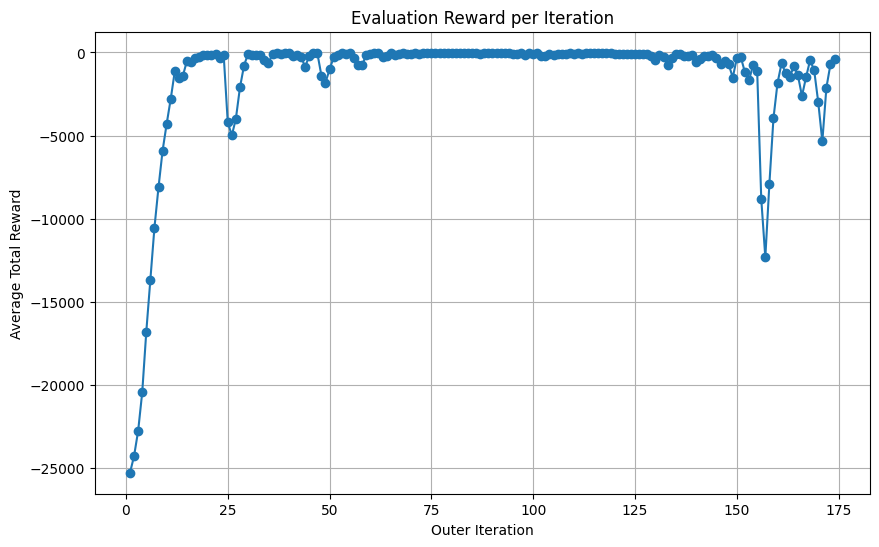

NameError: name 'path' is not defined

In [9]:
from matplotlib import pyplot as plt

# 보상 그래프 시각화 및 저장
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(reward_history) + 1), reward_history, marker='o')
plt.title("Evaluation Reward per Iteration")
plt.xlabel("Outer Iteration")
plt.ylabel("Average Total Reward")
plt.grid(True)
plt.show()
plot_file = path.join(results_dir, "reward_plot.png")
plt.savefig(plot_file)
print(f"Reward plot saved to {plot_file}")

In [ ]:


# 모델 체크포인트 저장
v_net_file = path.join(results_dir, "v_net.pth")
pi_net_file = path.join(results_dir, "pi_net.pth")
torch.save(v_net.state_dict(), v_net_file)
torch.save(pi_net.state_dict(), pi_net_file)
print(f"Value network saved to {v_net_file}")
print(f"Policy network saved to {pi_net_file}")





In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, eval_traj_len + 1), x_norm_hist_hist[-1].cpu().numpy(), linewidth=1.0)
plt.title("The last x norm trajectory")
plt.xlabel("time step")
plt.ylabel("x norm trajectory")
plt.grid(True)
plot_file = path.join(results_dir, "last_x_norm_trajectory.png")
plt.savefig(plot_file)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, outer_iters + 1), x_norm_hist_hist[:, -1].cpu().numpy(), linewidth=1.0)
plt.title("Final x norm")
plt.xlabel("Outer Iteration")
plt.ylabel("Final x norm")
plt.grid(True)
plot_file = path.join(results_dir, "Final_x_norm.png")
plt.savefig(plot_file)
plt.show()